In [1]:
import torch
import torchvision
from torch import nn, optim
from torchvision import datasets, transforms
import torch.nn.functional as F

import time

import numpy as np
import matplotlib.pyplot as plt

from utils_cifar10 import *
from models import ResNet18

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
transform_train = transforms.Compose([
#     transforms.CenterCrop(224),
    transforms.RandomCrop(32, padding=4), 
    transforms.RandomHorizontalFlip(),  
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
]) 


transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [4]:
trainset = datasets.CIFAR10(root='./data', train=True,download=True, transform=transform_train)
testset = datasets.CIFAR10(root='./data',train=False,download=True,transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

## ResNet18 Batch size 32

In [6]:
batch_size = 32

In [7]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,shuffle=False)

In [8]:
net = ResNet18().to(device)
if device == 'cuda':
    net = nn.DataParallel(net)
    torch.backends.cudnn.benchmark = True

In [9]:
epoch = 100

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3, weight_decay=5e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=3, min_lr=1e-5) 

In [10]:
Acc, Loss, Lr = train(net, trainloader, testloader, epoch, optimizer, criterion, scheduler)

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch [  1/100] | Train Loss:1.566455 | Train Acc:42.04% | Test Loss:1.265998 | Test Acc:53.95% | Learning Rate:0.001000 | Time: 01:13
Epoch [  2/100] | Train Loss:1.167873 | Train Acc:58.11% | Test Loss:1.077727 | Test Acc:61.62% | Learning Rate:0.001000 | Time: 01:16
Epoch [  3/100] | Train Loss:0.977443 | Train Acc:65.20% | Test Loss:1.098146 | Test Acc:63.87% | Learning Rate:0.001000 | Time: 01:14
Epoch [  4/100] | Train Loss:0.819575 | Train Acc:71.52% | Test Loss:0.799488 | Test Acc:72.96% | Learning Rate:0.001000 | Time: 01:15
Epoch [  5/100] | Train Loss:0.710208 | Train Acc:75.45% | Test Loss:0.673655 | Test Acc:77.02% | Learning Rate:0.001000 | Time: 01:14
Epoch [  6/100] | Train Loss:0.649228 | Train Acc:77.70% | Test Loss:0.605642 | Test Acc:79.04% | Learning Rate:0.001000 | Time: 01:16
Epoch [  7/100] | Train Loss:0.603512 | Train Acc:79.17% | Test Loss:0.656160 | Test Acc:77.55% | Learning Rate:0.001000 | Time: 01:13
Epoch [  8/100] | Train Loss:0.572683 | Train Acc:80.34

In [26]:
def plot_history(epoches, Acc, Loss, lr=None):
    plt.rcParams['figure.figsize'] = (10.0, 8.0)  # set default size of plots
    plt.rcParams['image.interpolation'] = 'nearest'
    plt.rcParams['image.cmap'] = 'gray'

    epoch_list = range(1,epoches + 1)
    plt.plot(epoch_list, Loss['train_loss'])
    plt.plot(epoch_list, Loss['test_loss'])
    plt.xlabel('epoch')
    plt.ylabel('Loss Value')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    plt.plot(epoch_list, Acc['train_acc'])
    plt.plot(epoch_list, Acc['test_acc'])
    plt.xlabel('epoch')
    plt.ylabel('Acc Value')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    plt.plot(epoch_list, lr)
    plt.xlabel('epoch')
    plt.ylabel('Train LR')
    plt.show()

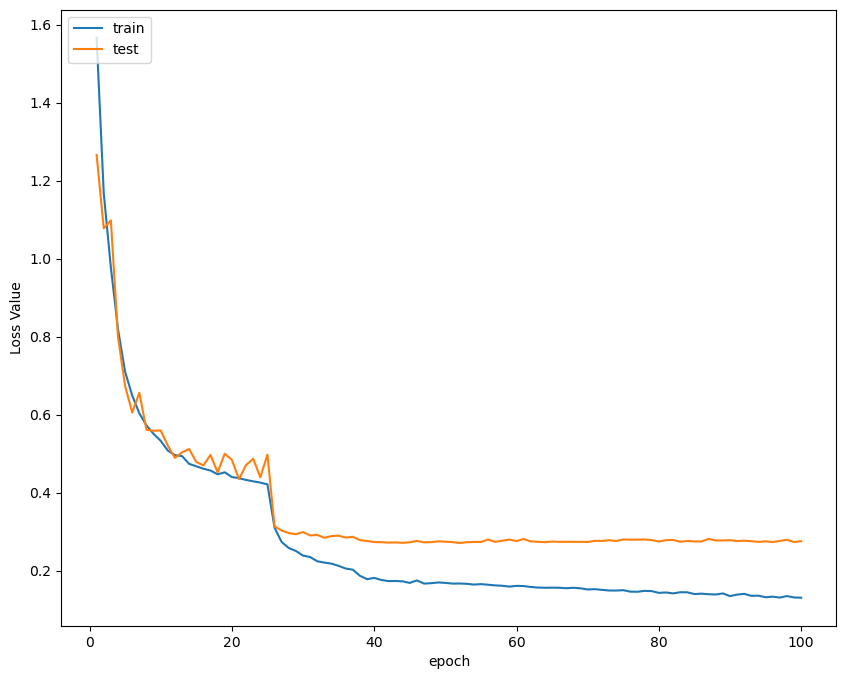

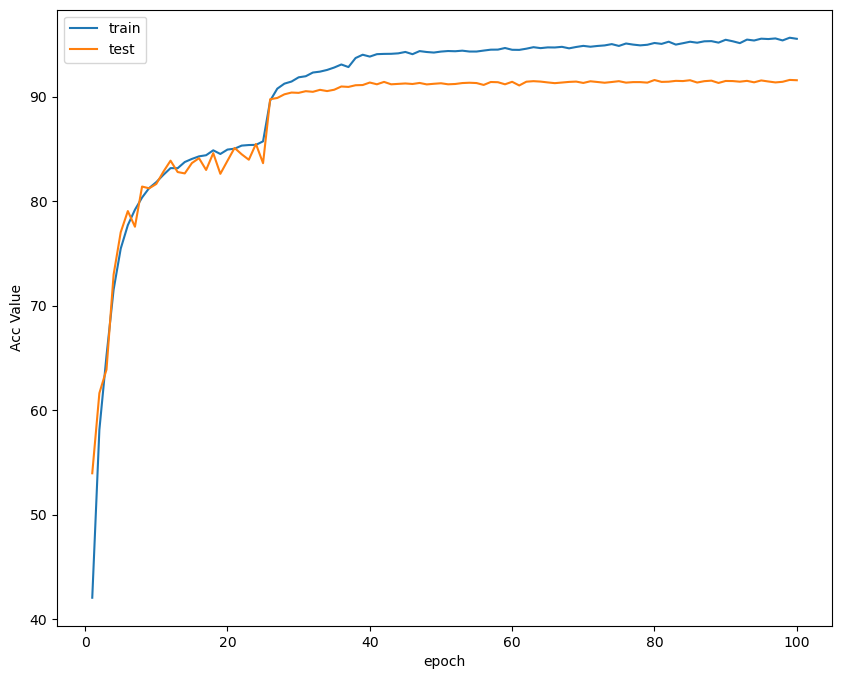

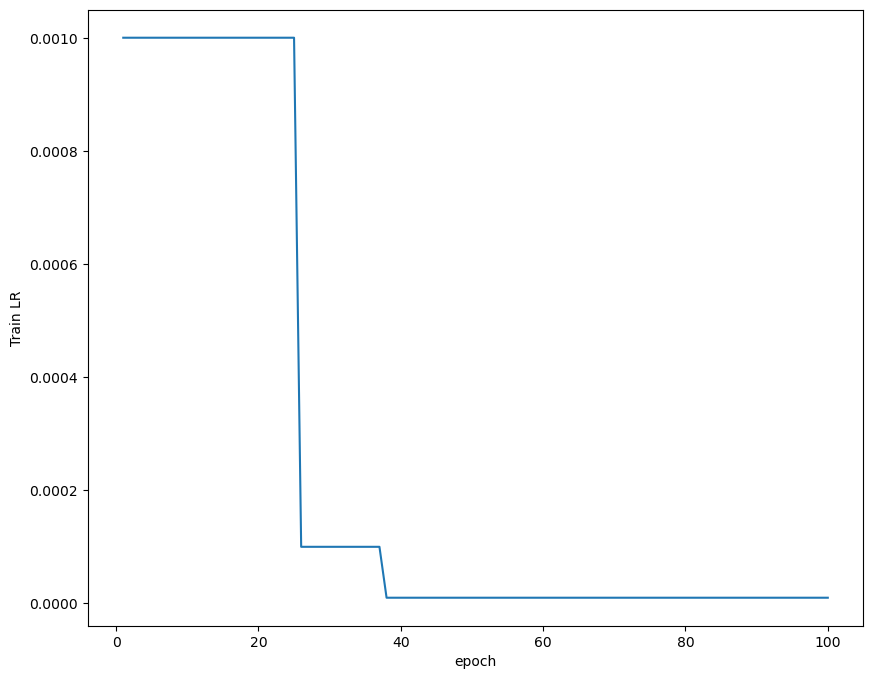

In [27]:
plot_history(epoch, Acc, Loss, Lr)

In [12]:
correct = 0 # Define the number of correctly predicted images, initialized to 0
total = 0 # The total number of pictures participating in the test, also initialized to 0
torch.cuda.empty_cache()
net.eval()
with torch.no_grad():
    for data in testloader: # Loop through each batch
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        net.eval() # Convert the model to test mode
        if hasattr(torch.cuda, 'empty_cache'):
            torch.cuda.empty_cache()
        outputs = net(images) # Enter the network for testing

        # outputs.data is a 4x10 tensor. The value and sequence number of the largest column of each row are formed into a one-dimensional tensor to return, the first is the value tensor, and the second is the sequence number tensor.
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0) # update the number of test images
        correct += (predicted == labels).sum() # update the number of correctly classified images

    print('Accuracy of the network on the 10000 test images: %.2f %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 91.56 %


In [13]:
# Define 2 lists that store the number of correct tests in each class, initialized to 0
class_correct = list(0.for i in range(10))
class_total = list(0.for i in range(10))
net.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        if hasattr(torch.cuda, 'empty_cache'):
            torch.cuda.empty_cache()
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
    #4 group (batch_size) data, output in the same label, marked as 1, otherwise 0
        c = (predicted == labels).squeeze()
        for i in range(len(images)): # Because each batch has 4 images, a small loop of 4 is needed
            label = labels[i] # Accumulate each class separately
            class_correct[label] += c[i]
            class_total[label] += 1
 
 
for i in range(10):
    print('Accuracy of %5s : %.2f %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 92.70 %
Accuracy of   car : 96.00 %
Accuracy of  bird : 89.80 %
Accuracy of   cat : 80.20 %
Accuracy of  deer : 91.90 %
Accuracy of   dog : 88.30 %
Accuracy of  frog : 94.40 %
Accuracy of horse : 92.90 %
Accuracy of  ship : 94.80 %
Accuracy of truck : 94.60 %


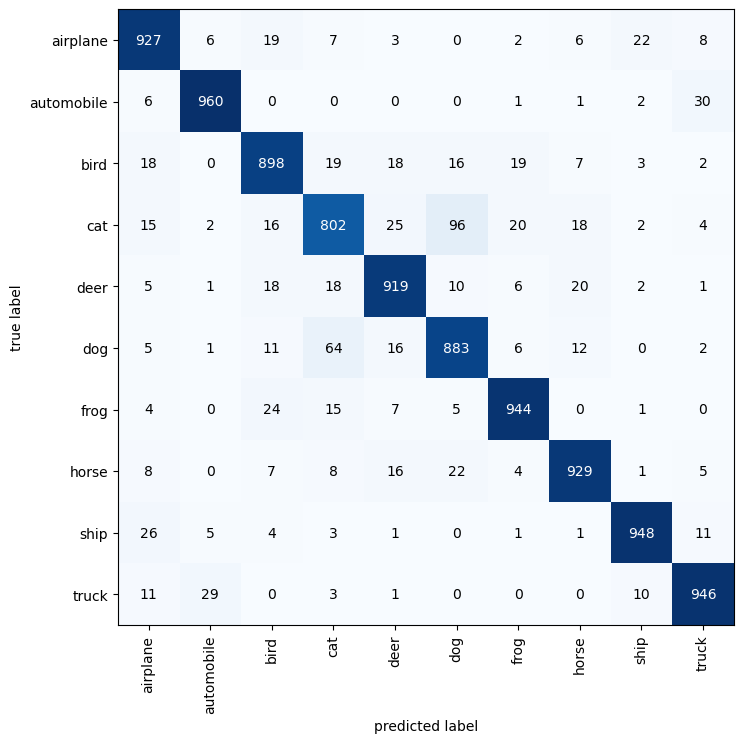

In [14]:
class_dict = {0: 'airplane',
              1: 'automobile',
              2: 'bird',
              3: 'cat',
              4: 'deer',
              5: 'dog',
              6: 'frog',
              7: 'horse',
              8: 'ship',
              9: 'truck'}

mat = compute_confusion_matrix(model=net, data_loader=testloader, device=torch.device('cpu'))
plot_confusion_matrix(mat, class_names=class_dict.values())
plt.show()

In [20]:
def imshow(img):
    img = img / 2 + 0.5
    img = np.transpose(img.numpy(),(1,2,0))
    plt.imshow(img)

Accuracy Rate = 93.75%


<Figure size 2500x400 with 0 Axes>

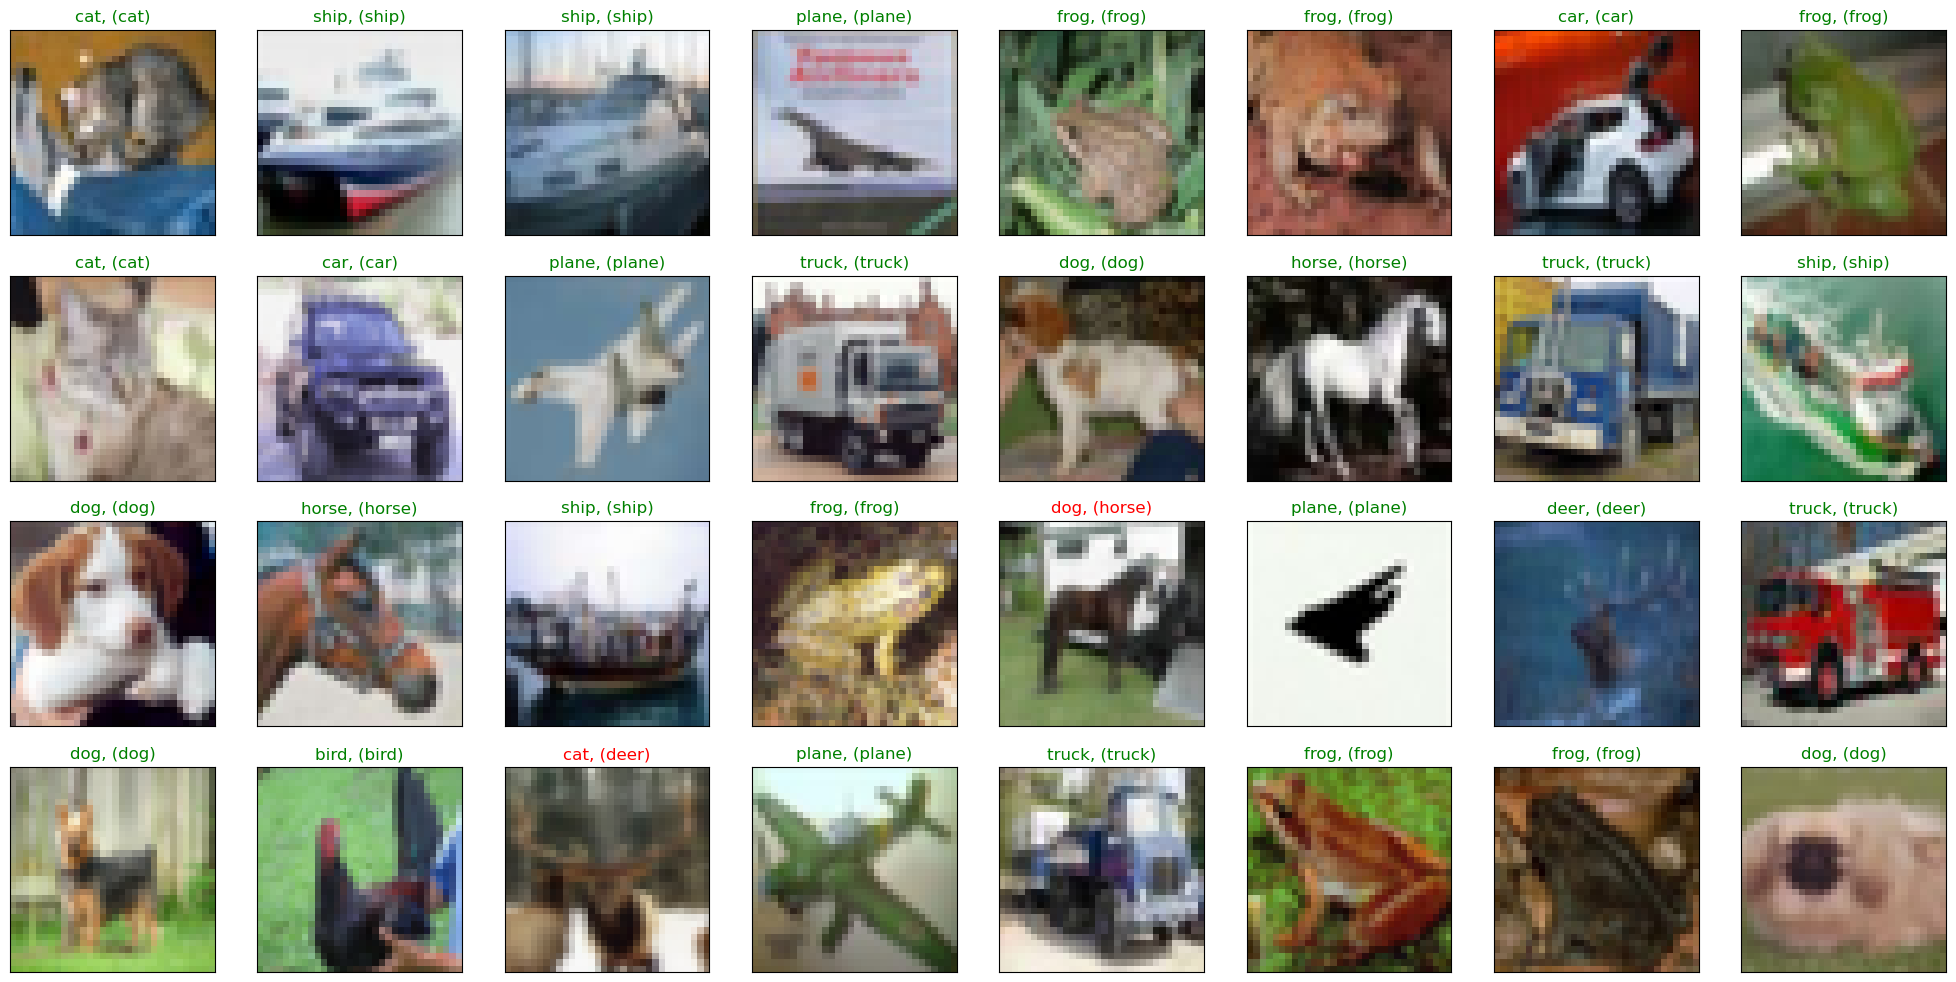

In [21]:
dataiter = iter(testloader)
images, labels = next(dataiter)
images_ = images
images_ = images_.to(device)
labels = labels.to(device)
val_output = net(images_)
_, val_preds = torch.max(val_output, 1)

fig = plt.figure(figsize=(25,4))

correct = torch.sum(val_preds == labels.data).item()

val_preds = val_preds.cpu()
labels = labels.cpu()

print("Accuracy Rate = {}%".format(correct/len(images) * 100))

fig = plt.figure(figsize=(25,25))
for idx in np.arange(32):    
    ax = fig.add_subplot(8, 8, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(
        "{}, ({})".format(classes[val_preds[idx].item()], classes[labels[idx].item()]), 
        color = ("green" if val_preds[idx].item()==labels[idx].item() else "red")
    )

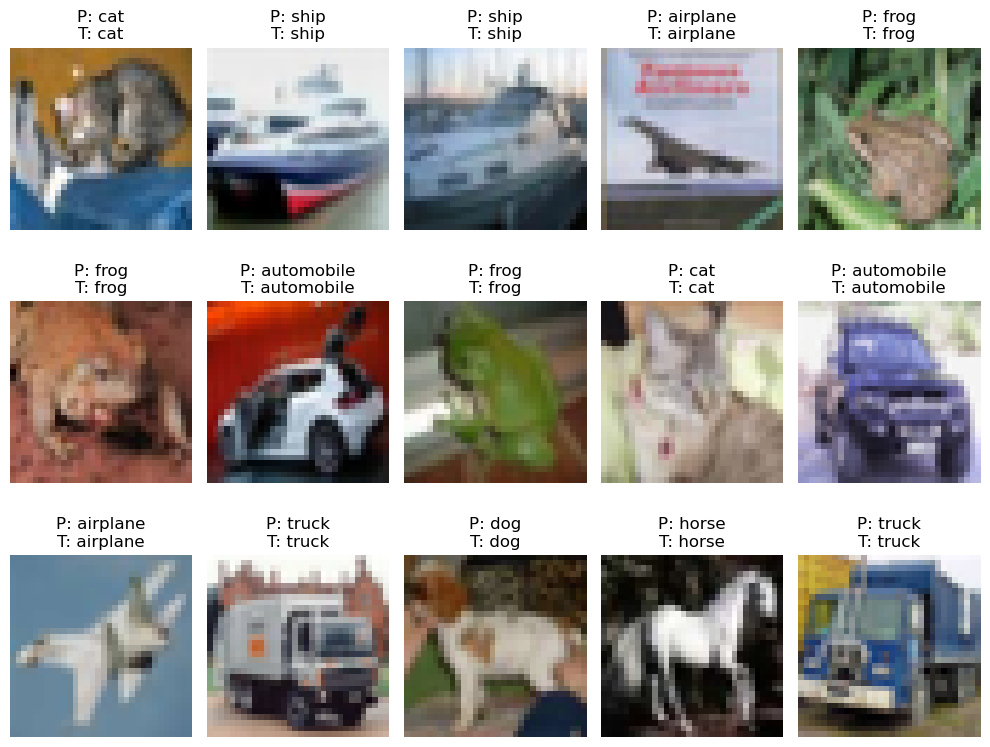

In [22]:
unnormalizer = UnNormalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

show_examples(model=net, data_loader=testloader, unnormalizer=unnormalizer, class_dict=class_dict)

## ResNet18 Batch size 64

In [28]:
batch_size = 64

In [29]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,shuffle=False)

In [30]:
net = ResNet18().to(device)
if device == 'cuda':
    net = nn.DataParallel(net)
    torch.backends.cudnn.benchmark = True

In [31]:
epoch = 100

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3, weight_decay=5e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=3, min_lr=1e-5) 

In [32]:
Acc, Loss, Lr = train(net, trainloader, testloader, epoch, optimizer, criterion, scheduler)

Epoch [  1/100] | Train Loss:1.509647 | Train Acc:44.66% | Test Loss:1.318215 | Test Acc:52.36% | Learning Rate:0.001000 | Time: 01:23
Epoch [  2/100] | Train Loss:1.069657 | Train Acc:61.87% | Test Loss:0.979768 | Test Acc:65.47% | Learning Rate:0.001000 | Time: 01:22
Epoch [  3/100] | Train Loss:0.874362 | Train Acc:69.44% | Test Loss:0.925950 | Test Acc:68.30% | Learning Rate:0.001000 | Time: 01:19
Epoch [  4/100] | Train Loss:0.741755 | Train Acc:74.21% | Test Loss:0.936307 | Test Acc:68.90% | Learning Rate:0.001000 | Time: 01:19
Epoch [  5/100] | Train Loss:0.660861 | Train Acc:77.41% | Test Loss:0.737821 | Test Acc:76.47% | Learning Rate:0.001000 | Time: 01:19
Epoch [  6/100] | Train Loss:0.595326 | Train Acc:79.70% | Test Loss:0.776533 | Test Acc:74.55% | Learning Rate:0.001000 | Time: 01:19
Epoch [  7/100] | Train Loss:0.549195 | Train Acc:81.17% | Test Loss:0.682111 | Test Acc:77.30% | Learning Rate:0.001000 | Time: 01:20
Epoch [  8/100] | Train Loss:0.514438 | Train Acc:82.47

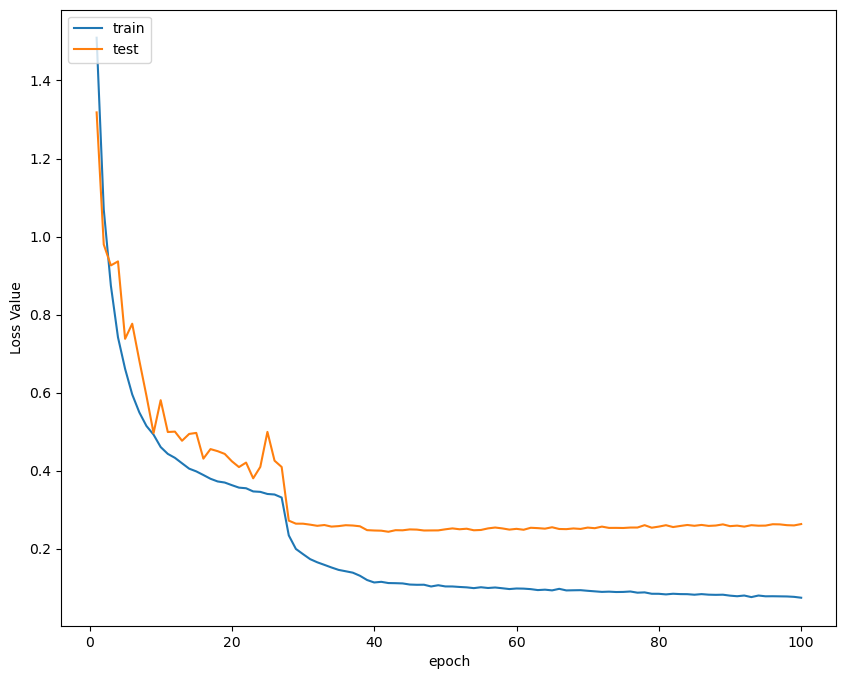

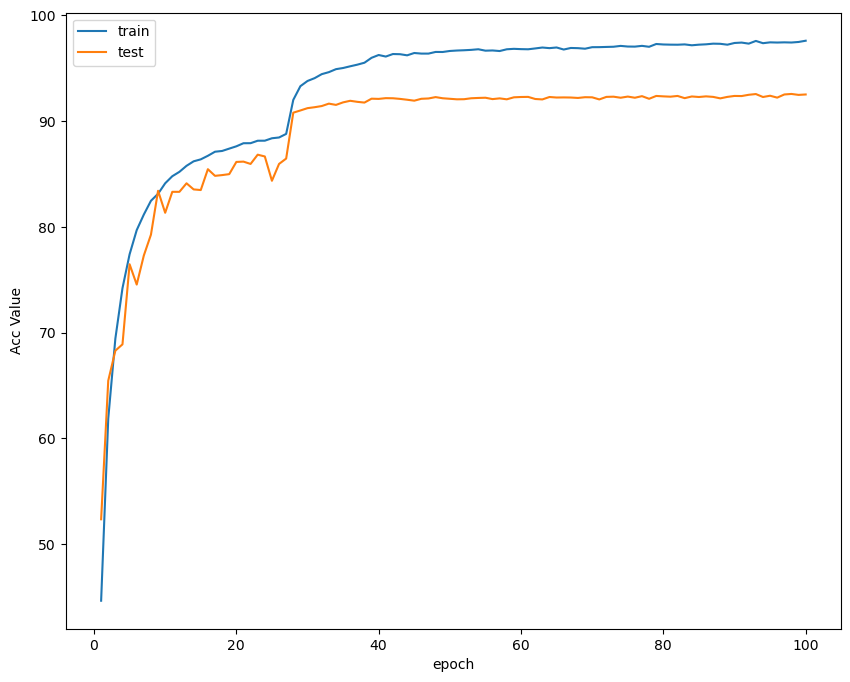

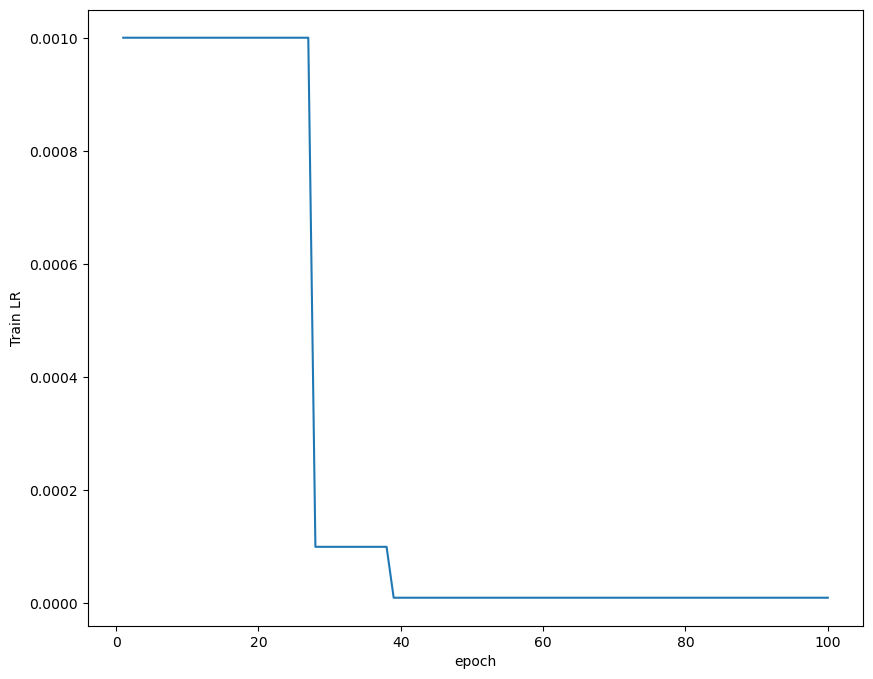

In [33]:
plot_history(epoch ,Acc, Loss, Lr)

In [34]:
correct = 0 # Define the number of correctly predicted images, initialized to 0
total = 0 # The total number of pictures participating in the test, also initialized to 0
torch.cuda.empty_cache()
net.eval()
with torch.no_grad():
    for data in testloader: # Loop through each batch
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        net.eval() # Convert the model to test mode
        if hasattr(torch.cuda, 'empty_cache'):
            torch.cuda.empty_cache()
        outputs = net(images) # Enter the network for testing

        # outputs.data is a 4x10 tensor. The value and sequence number of the largest column of each row are formed into a one-dimensional tensor to return, the first is the value tensor, and the second is the sequence number tensor.
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0) # update the number of test images
        correct += (predicted == labels).sum() # update the number of correctly classified images

    print('Accuracy of the network on the 10000 test images: %.2f %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 92.49 %


In [35]:
# Define 2 lists that store the number of correct tests in each class, initialized to 0
class_correct = list(0.for i in range(10))
class_total = list(0.for i in range(10))
net.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        if hasattr(torch.cuda, 'empty_cache'):
            torch.cuda.empty_cache()
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
    #4 group (batch_size) data, output in the same label, marked as 1, otherwise 0
        c = (predicted == labels).squeeze()
        for i in range(len(images)): # Because each batch has 4 images, a small loop of 4 is needed
            label = labels[i] # Accumulate each class separately
            class_correct[label] += c[i]
            class_total[label] += 1
 
 
for i in range(10):
    print('Accuracy of %5s : %.2f %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 92.80 %
Accuracy of   car : 96.70 %
Accuracy of  bird : 88.80 %
Accuracy of   cat : 86.40 %
Accuracy of  deer : 92.30 %
Accuracy of   dog : 89.60 %
Accuracy of  frog : 94.80 %
Accuracy of horse : 93.50 %
Accuracy of  ship : 95.10 %
Accuracy of truck : 94.90 %


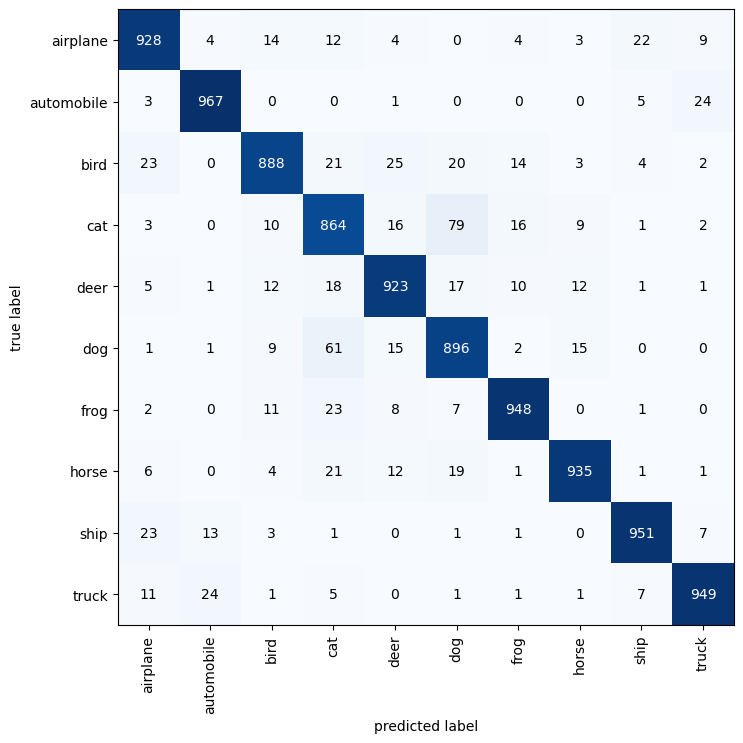

In [36]:
class_dict = {0: 'airplane',
              1: 'automobile',
              2: 'bird',
              3: 'cat',
              4: 'deer',
              5: 'dog',
              6: 'frog',
              7: 'horse',
              8: 'ship',
              9: 'truck'}

mat = compute_confusion_matrix(model=net, data_loader=testloader, device=torch.device('cpu'))
plot_confusion_matrix(mat, class_names=class_dict.values())
plt.show()

Accuracy Rate = 92.1875%


<Figure size 2500x400 with 0 Axes>

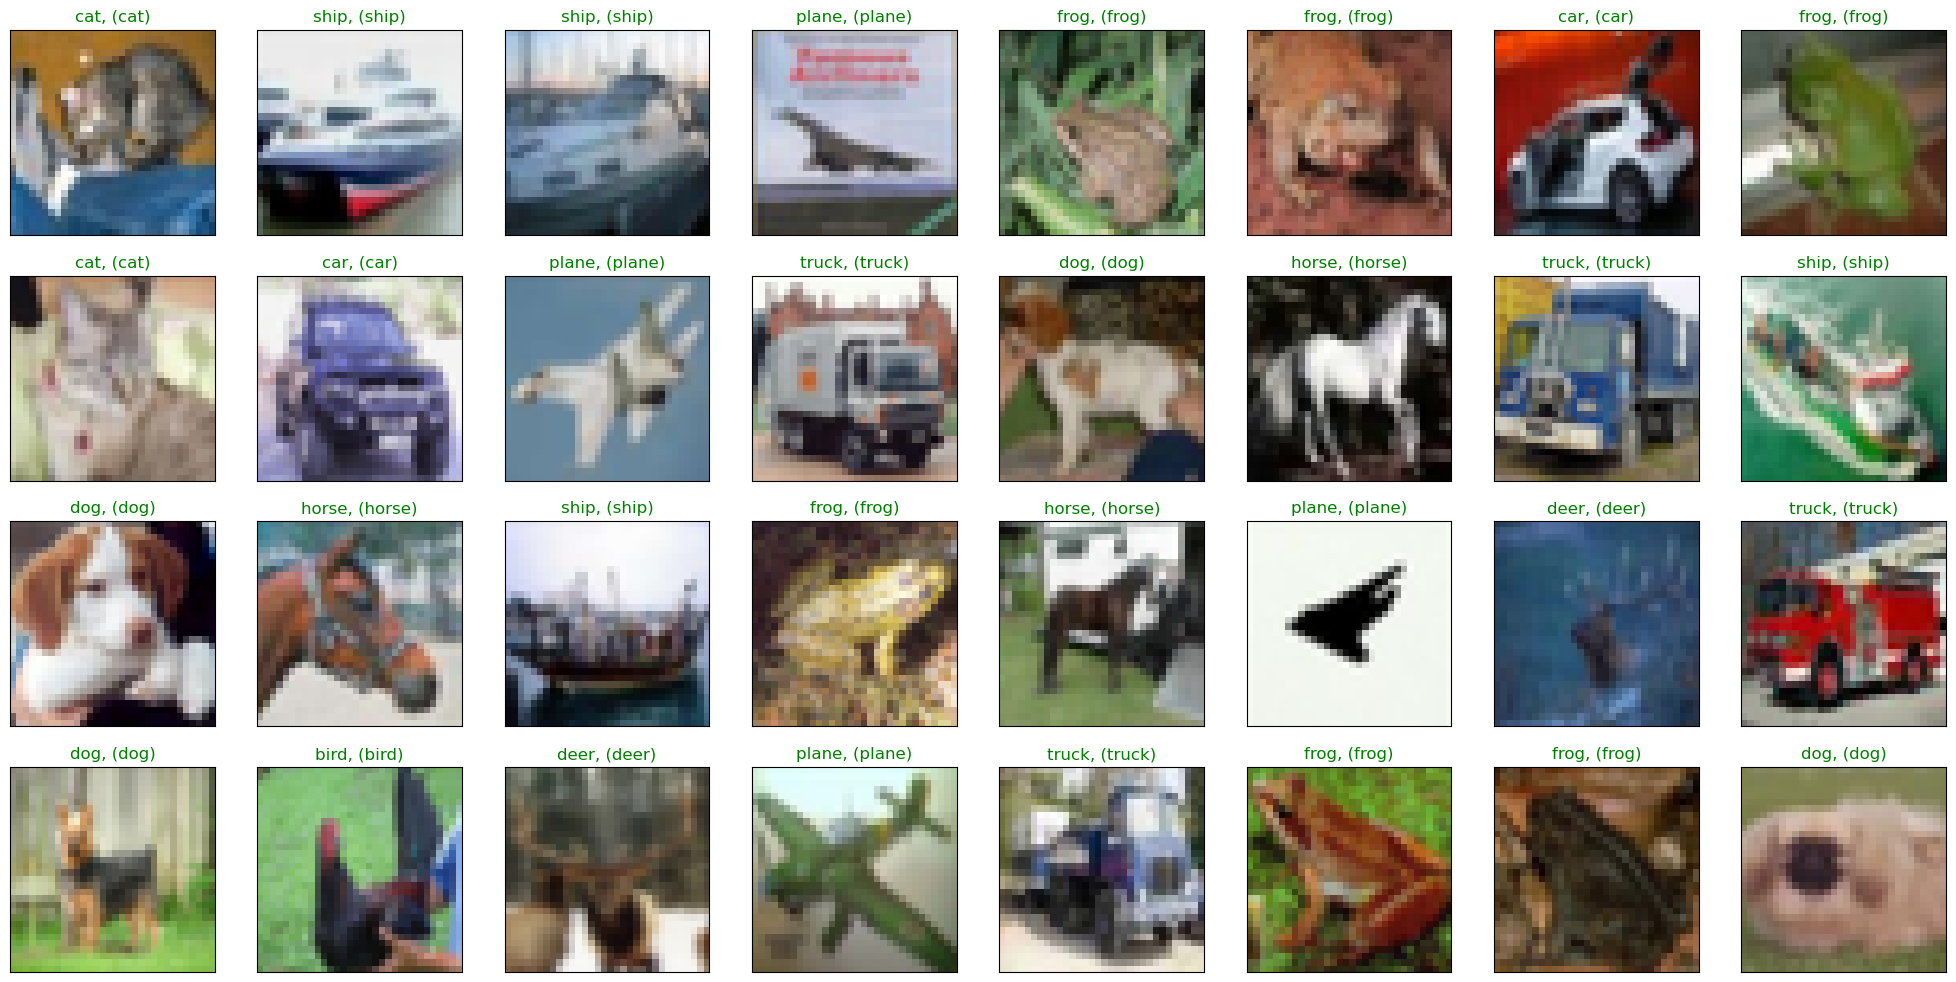

In [37]:
dataiter = iter(testloader)
images, labels = next(dataiter)
images_ = images
images_ = images_.to(device)
labels = labels.to(device)
val_output = net(images_)
_, val_preds = torch.max(val_output, 1)

fig = plt.figure(figsize=(25,4))

correct = torch.sum(val_preds == labels.data).item()

val_preds = val_preds.cpu()
labels = labels.cpu()

print("Accuracy Rate = {}%".format(correct/len(images) * 100))

fig = plt.figure(figsize=(25,25))
for idx in np.arange(32):    
    ax = fig.add_subplot(8, 8, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(
        "{}, ({})".format(classes[val_preds[idx].item()], classes[labels[idx].item()]), 
        color = ("green" if val_preds[idx].item()==labels[idx].item() else "red")
    )

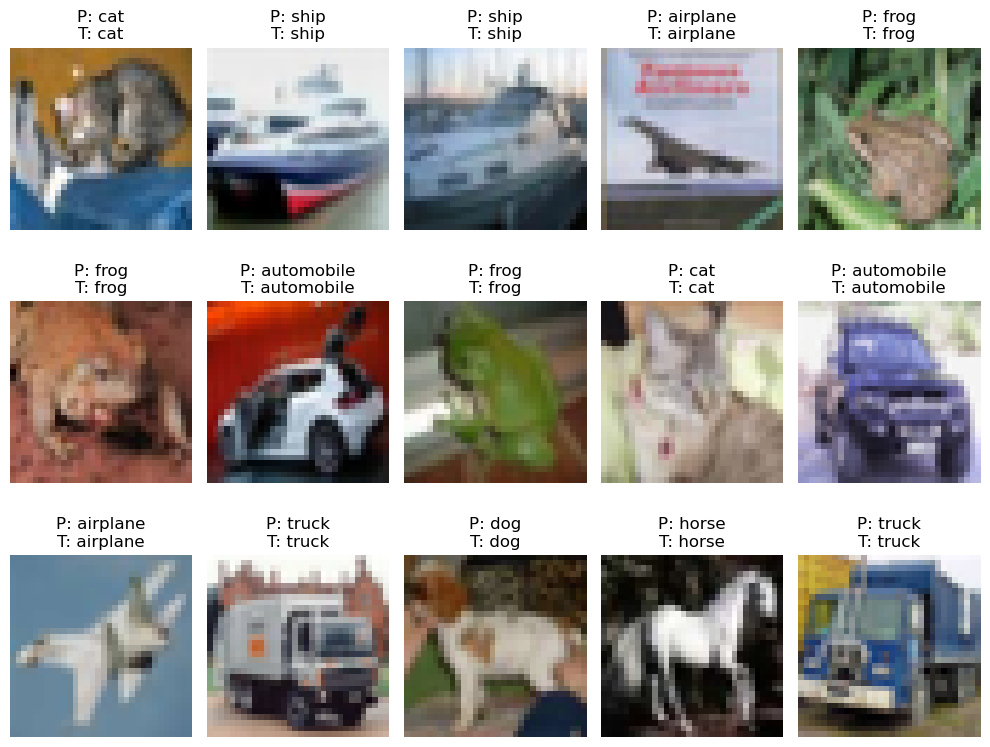

In [38]:
unnormalizer = UnNormalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

show_examples(model=net, data_loader=testloader, unnormalizer=unnormalizer, class_dict=class_dict)

## ResNet18 Batch size 128

In [39]:
batch_size = 128

In [40]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,shuffle=False)

In [41]:
net = ResNet18().to(device)
if device == 'cuda':
    net = nn.DataParallel(net)
    torch.backends.cudnn.benchmark = True

In [44]:
epoch = 100

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3, weight_decay=5e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=3, min_lr=1e-5) 

In [45]:
Acc, Loss, Lr = train(net, trainloader, testloader, epoch, optimizer, criterion, scheduler)

Epoch [  1/100] | Train Loss:0.256538 | Train Acc:91.23% | Test Loss:0.392038 | Test Acc:87.65% | Learning Rate:0.001000 | Time: 00:43
Epoch [  2/100] | Train Loss:0.250923 | Train Acc:91.38% | Test Loss:0.468065 | Test Acc:85.62% | Learning Rate:0.001000 | Time: 00:44
Epoch [  3/100] | Train Loss:0.250577 | Train Acc:91.37% | Test Loss:0.412546 | Test Acc:86.86% | Learning Rate:0.001000 | Time: 00:45
Epoch [  4/100] | Train Loss:0.246305 | Train Acc:91.68% | Test Loss:0.449680 | Test Acc:86.47% | Learning Rate:0.001000 | Time: 00:51
Epoch [  5/100] | Train Loss:0.248234 | Train Acc:91.49% | Test Loss:0.411576 | Test Acc:86.99% | Learning Rate:0.001000 | Time: 00:51
Epoch [  6/100] | Train Loss:0.146914 | Train Acc:95.08% | Test Loss:0.251095 | Test Acc:92.09% | Learning Rate:0.000100 | Time: 00:51
Epoch [  7/100] | Train Loss:0.116457 | Train Acc:96.17% | Test Loss:0.244913 | Test Acc:92.30% | Learning Rate:0.000100 | Time: 00:51
Epoch [  8/100] | Train Loss:0.100241 | Train Acc:96.79

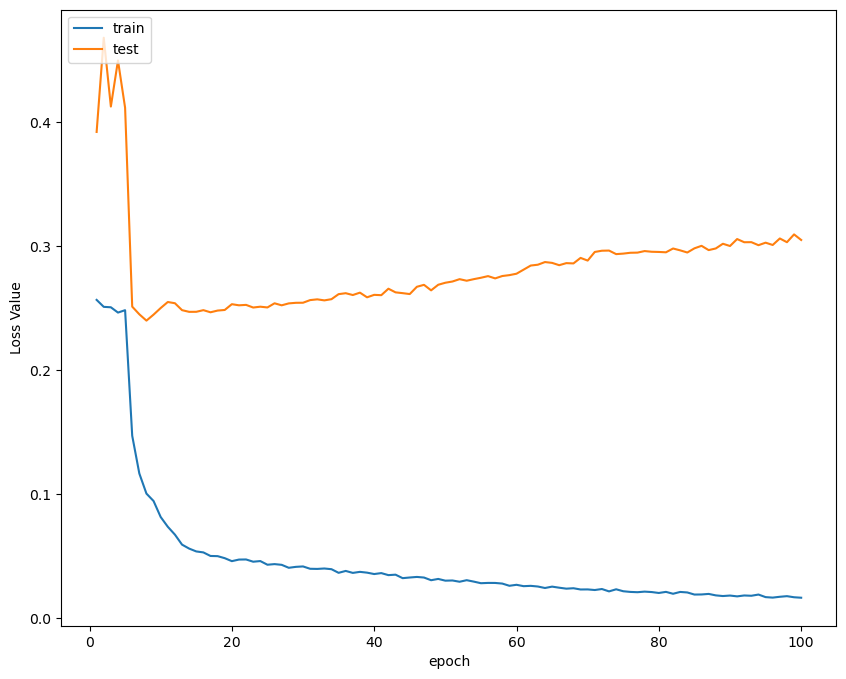

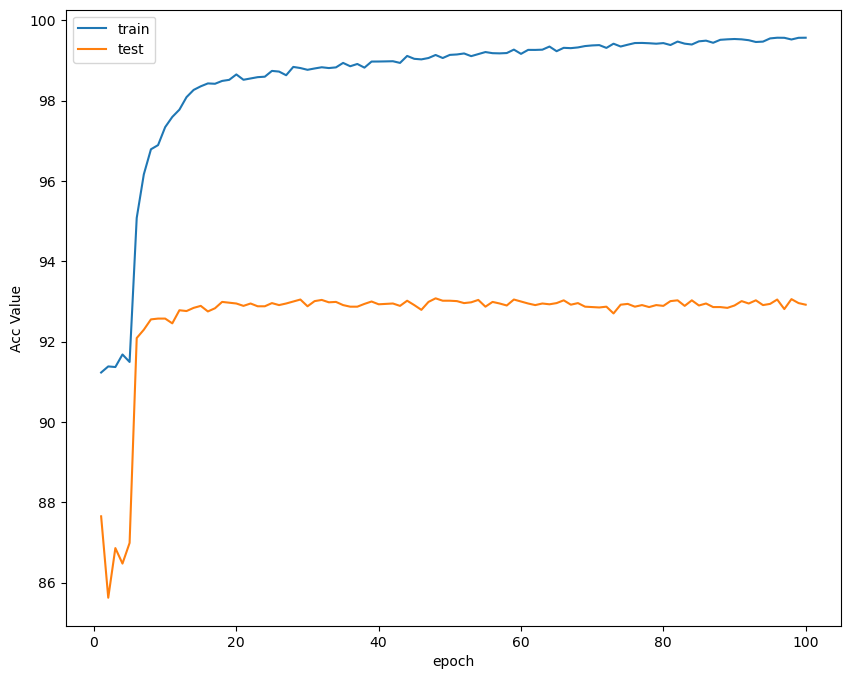

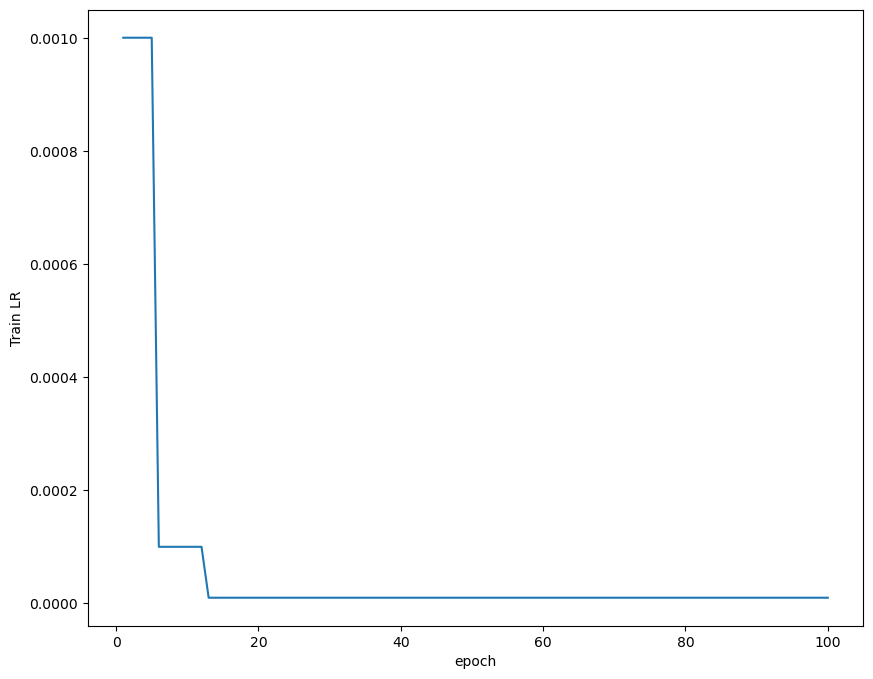

In [46]:
plot_history(epoch ,Acc, Loss, Lr)

In [47]:
correct = 0 # Define the number of correctly predicted images, initialized to 0
total = 0 # The total number of pictures participating in the test, also initialized to 0
torch.cuda.empty_cache()
net.eval()
with torch.no_grad():
    for data in testloader: # Loop through each batch
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        net.eval() # Convert the model to test mode
        if hasattr(torch.cuda, 'empty_cache'):
            torch.cuda.empty_cache()
        outputs = net(images) # Enter the network for testing

        # outputs.data is a 4x10 tensor. The value and sequence number of the largest column of each row are formed into a one-dimensional tensor to return, the first is the value tensor, and the second is the sequence number tensor.
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0) # update the number of test images
        correct += (predicted == labels).sum() # update the number of correctly classified images

    print('Accuracy of the network on the 10000 test images: %.2f %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 92.91 %


In [48]:
# Define 2 lists that store the number of correct tests in each class, initialized to 0
class_correct = list(0.for i in range(10))
class_total = list(0.for i in range(10))
net.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        if hasattr(torch.cuda, 'empty_cache'):
            torch.cuda.empty_cache()
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
    #4 group (batch_size) data, output in the same label, marked as 1, otherwise 0
        c = (predicted == labels).squeeze()
        for i in range(len(images)): # Because each batch has 4 images, a small loop of 4 is needed
            label = labels[i] # Accumulate each class separately
            class_correct[label] += c[i]
            class_total[label] += 1
 
 
for i in range(10):
    print('Accuracy of %5s : %.2f %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 94.20 %
Accuracy of   car : 97.10 %
Accuracy of  bird : 90.30 %
Accuracy of   cat : 87.30 %
Accuracy of  deer : 94.80 %
Accuracy of   dog : 88.00 %
Accuracy of  frog : 93.80 %
Accuracy of horse : 93.90 %
Accuracy of  ship : 95.20 %
Accuracy of truck : 94.50 %


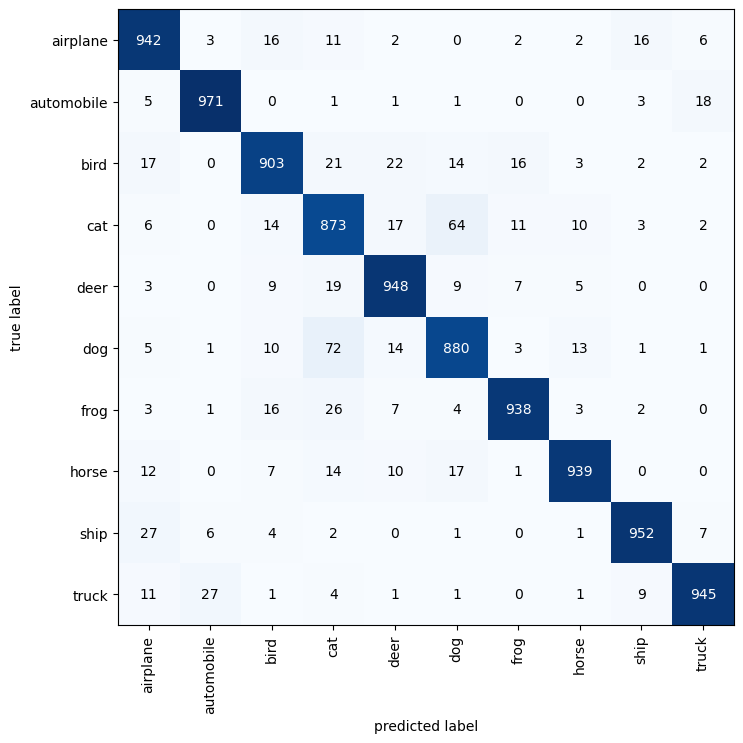

In [49]:
class_dict = {0: 'airplane',
              1: 'automobile',
              2: 'bird',
              3: 'cat',
              4: 'deer',
              5: 'dog',
              6: 'frog',
              7: 'horse',
              8: 'ship',
              9: 'truck'}

mat = compute_confusion_matrix(model=net, data_loader=testloader, device=torch.device('cpu'))
plot_confusion_matrix(mat, class_names=class_dict.values())
plt.show()

Accuracy Rate = 96.09375%


<Figure size 2500x400 with 0 Axes>

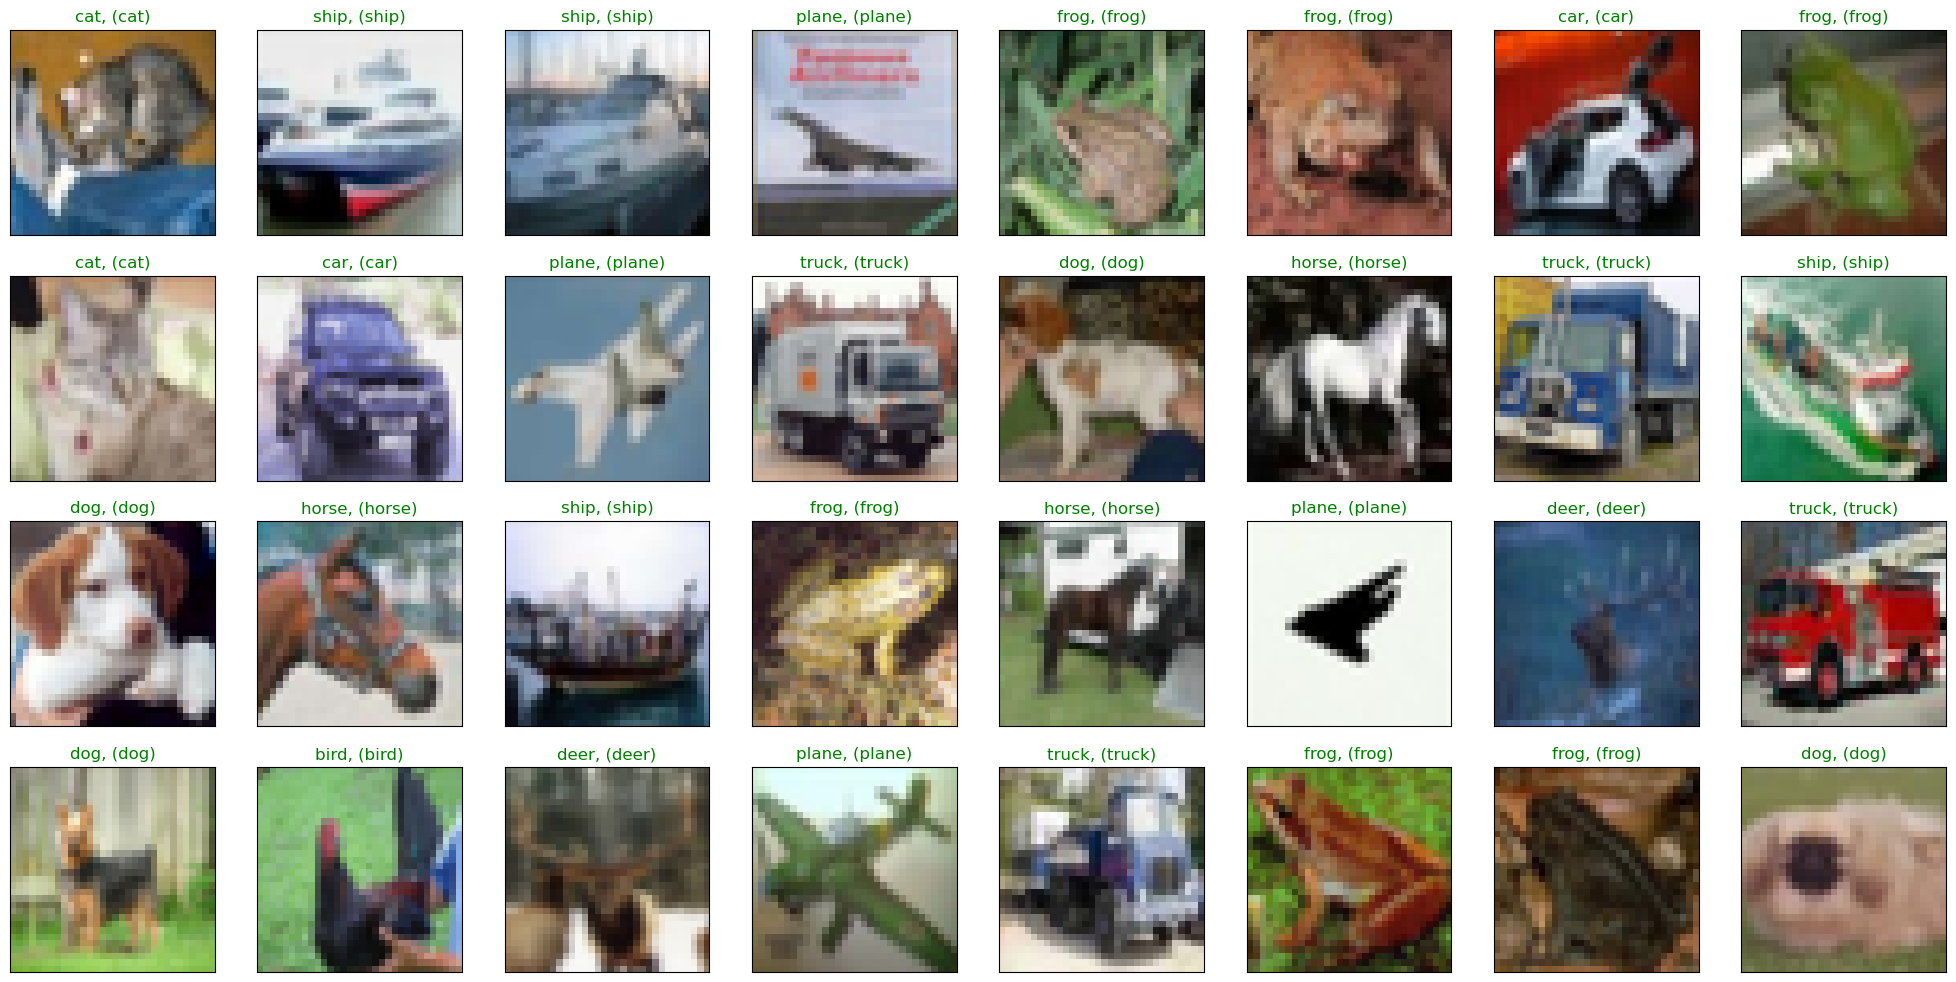

In [50]:
dataiter = iter(testloader)
images, labels = next(dataiter)
images_ = images
images_ = images_.to(device)
labels = labels.to(device)
val_output = net(images_)
_, val_preds = torch.max(val_output, 1)

fig = plt.figure(figsize=(25,4))

correct = torch.sum(val_preds == labels.data).item()

val_preds = val_preds.cpu()
labels = labels.cpu()

print("Accuracy Rate = {}%".format(correct/len(images) * 100))

fig = plt.figure(figsize=(25,25))
for idx in np.arange(32):    
    ax = fig.add_subplot(8, 8, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(
        "{}, ({})".format(classes[val_preds[idx].item()], classes[labels[idx].item()]), 
        color = ("green" if val_preds[idx].item()==labels[idx].item() else "red")
    )

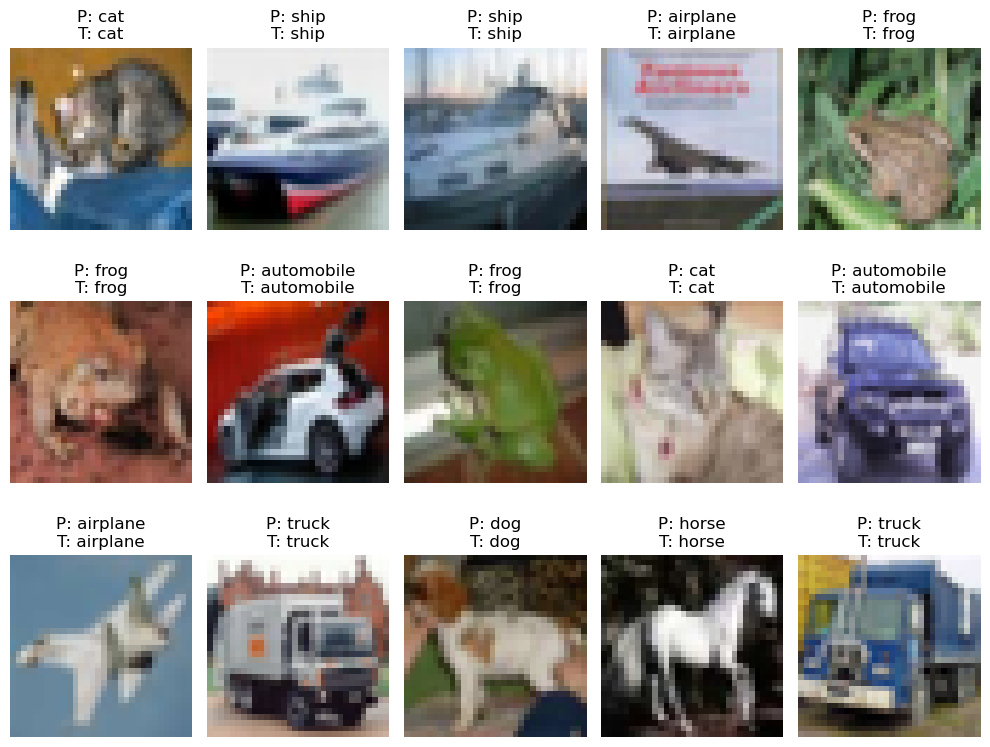

In [51]:
unnormalizer = UnNormalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

show_examples(model=net, data_loader=testloader, unnormalizer=unnormalizer, class_dict=class_dict)

## ResNet18 Batch size 16

In [6]:
batch_size = 16

In [7]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,shuffle=False)

In [8]:
net = ResNet18().to(device)
if device == 'cuda':
    net = nn.DataParallel(net)
    torch.backends.cudnn.benchmark = True

In [9]:
epoch = 100

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3, weight_decay=5e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=3, min_lr=1e-5) 

In [10]:
Acc, Loss, Lr = train(net, trainloader, testloader, epoch, optimizer, criterion, scheduler)

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch [  1/100] | Train Loss:1.630171 | Train Acc:39.63% | Test Loss:1.329485 | Test Acc:51.57% | Learning Rate:0.001000 | Time: 01:51
Epoch [  2/100] | Train Loss:1.212325 | Train Acc:56.80% | Test Loss:1.101900 | Test Acc:61.00% | Learning Rate:0.001000 | Time: 01:50
Epoch [  3/100] | Train Loss:1.010072 | Train Acc:64.26% | Test Loss:0.916985 | Test Acc:67.03% | Learning Rate:0.001000 | Time: 01:48
Epoch [  4/100] | Train Loss:0.872650 | Train Acc:69.46% | Test Loss:0.760351 | Test Acc:73.63% | Learning Rate:0.001000 | Time: 01:50
Epoch [  5/100] | Train Loss:0.779588 | Train Acc:73.18% | Test Loss:0.703826 | Test Acc:75.73% | Learning Rate:0.001000 | Time: 01:51
Epoch [  6/100] | Train Loss:0.717165 | Train Acc:75.22% | Test Loss:0.663770 | Test Acc:77.56% | Learning Rate:0.001000 | Time: 01:48
Epoch [  7/100] | Train Loss:0.687690 | Train Acc:76.42% | Test Loss:0.637850 | Test Acc:78.17% | Learning Rate:0.001000 | Time: 01:50
Epoch [  8/100] | Train Loss:0.656833 | Train Acc:77.78

In [11]:
def plot_history(epoches, Acc, Loss, lr=None):
    plt.rcParams['figure.figsize'] = (10.0, 8.0)  # set default size of plots
    plt.rcParams['image.interpolation'] = 'nearest'
    plt.rcParams['image.cmap'] = 'gray'

    epoch_list = range(1,epoches + 1)
    plt.plot(epoch_list, Loss['train_loss'])
    plt.plot(epoch_list, Loss['test_loss'])
    plt.xlabel('epoch')
    plt.ylabel('Loss Value')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    plt.plot(epoch_list, Acc['train_acc'])
    plt.plot(epoch_list, Acc['test_acc'])
    plt.xlabel('epoch')
    plt.ylabel('Acc Value')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    plt.plot(epoch_list, lr)
    plt.xlabel('epoch')
    plt.ylabel('Train LR')
    plt.show()

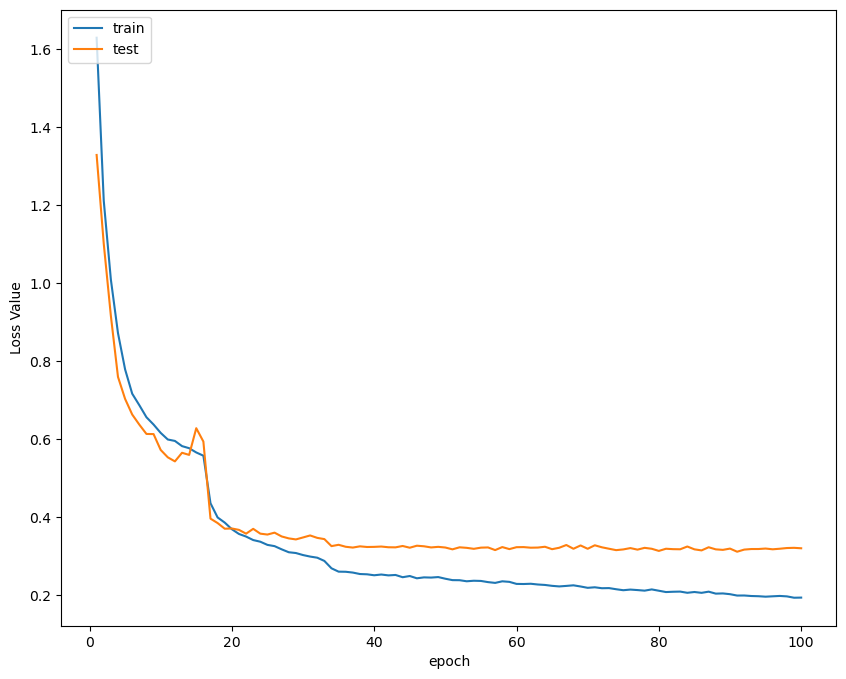

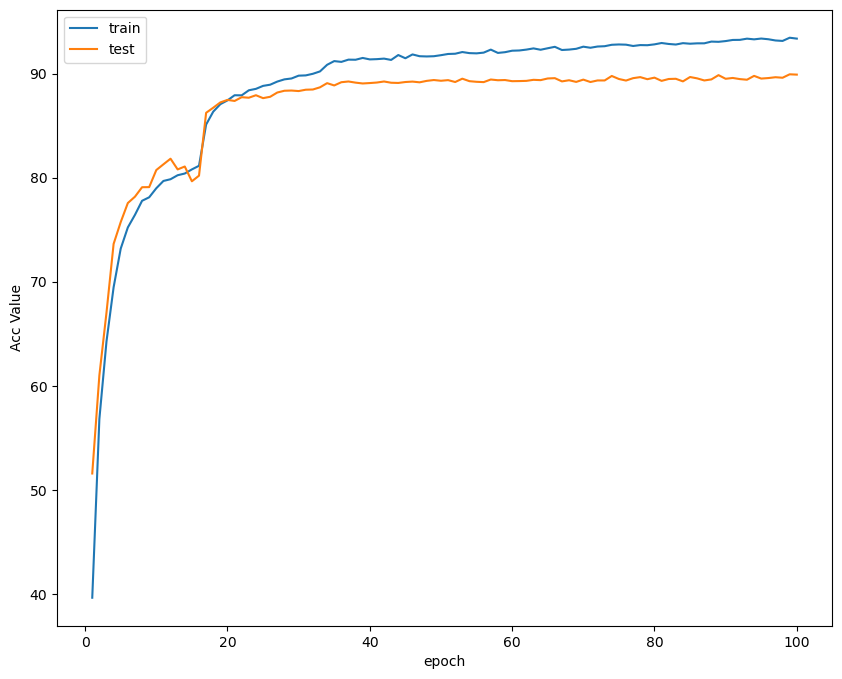

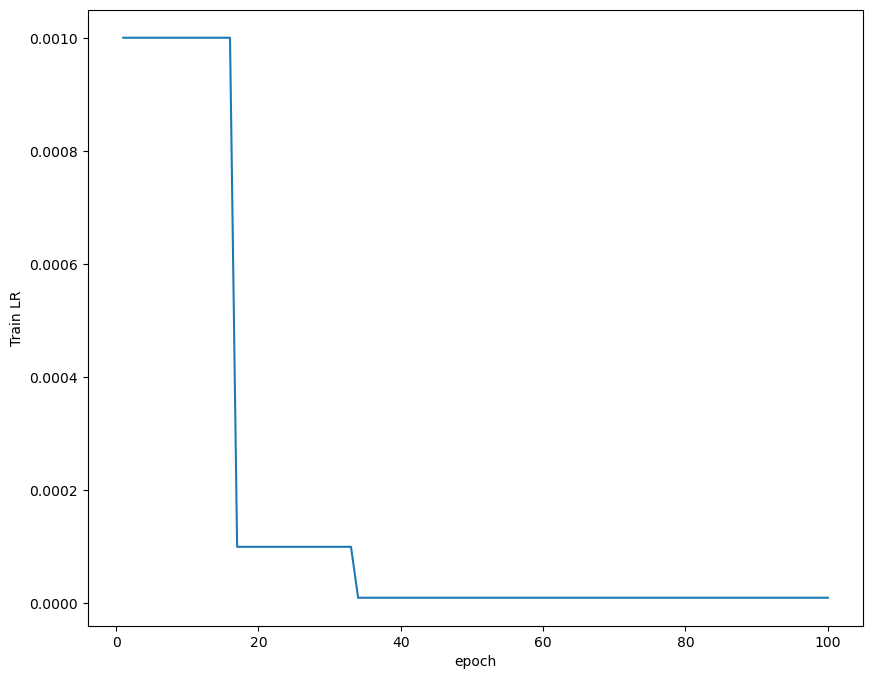

In [12]:
plot_history(epoch, Acc, Loss, Lr)

In [13]:
correct = 0 # Define the number of correctly predicted images, initialized to 0
total = 0 # The total number of pictures participating in the test, also initialized to 0
torch.cuda.empty_cache()
net.eval()
with torch.no_grad():
    for data in testloader: # Loop through each batch
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        net.eval() # Convert the model to test mode
        if hasattr(torch.cuda, 'empty_cache'):
            torch.cuda.empty_cache()
        outputs = net(images) # Enter the network for testing

        # outputs.data is a 4x10 tensor. The value and sequence number of the largest column of each row are formed into a one-dimensional tensor to return, the first is the value tensor, and the second is the sequence number tensor.
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0) # update the number of test images
        correct += (predicted == labels).sum() # update the number of correctly classified images

    print('Accuracy of the network on the 10000 test images: %.2f %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 89.90 %


In [14]:
# Define 2 lists that store the number of correct tests in each class, initialized to 0
class_correct = list(0.for i in range(10))
class_total = list(0.for i in range(10))
net.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        if hasattr(torch.cuda, 'empty_cache'):
            torch.cuda.empty_cache()
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
    #4 group (batch_size) data, output in the same label, marked as 1, otherwise 0
        c = (predicted == labels).squeeze()
        for i in range(len(images)): # Because each batch has 4 images, a small loop of 4 is needed
            label = labels[i] # Accumulate each class separately
            class_correct[label] += c[i]
            class_total[label] += 1
 
 
for i in range(10):
    print('Accuracy of %5s : %.2f %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 90.60 %
Accuracy of   car : 95.00 %
Accuracy of  bird : 88.10 %
Accuracy of   cat : 75.10 %
Accuracy of  deer : 89.70 %
Accuracy of   dog : 86.10 %
Accuracy of  frog : 92.00 %
Accuracy of horse : 93.90 %
Accuracy of  ship : 94.30 %
Accuracy of truck : 94.20 %


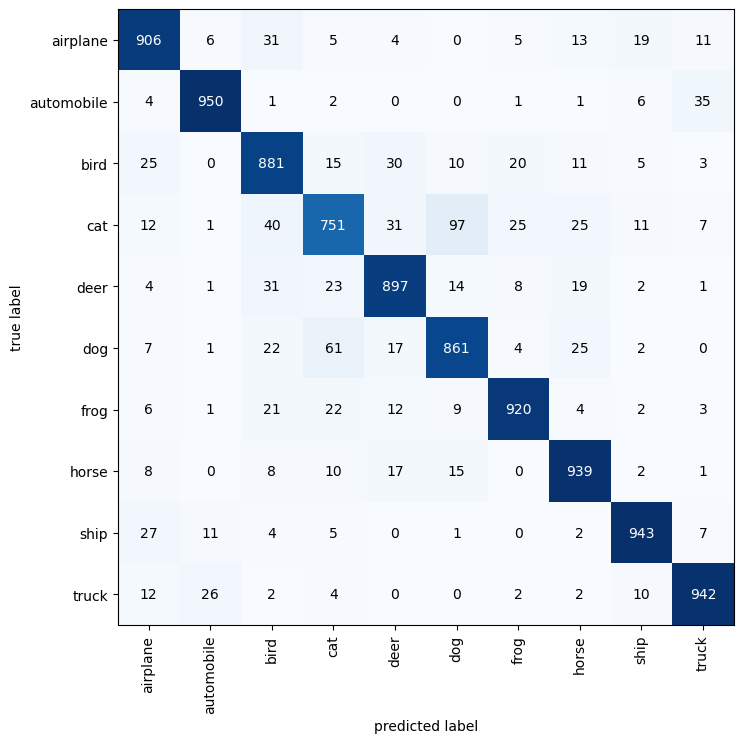

In [15]:
class_dict = {0: 'airplane',
              1: 'automobile',
              2: 'bird',
              3: 'cat',
              4: 'deer',
              5: 'dog',
              6: 'frog',
              7: 'horse',
              8: 'ship',
              9: 'truck'}

mat = compute_confusion_matrix(model=net, data_loader=testloader, device=torch.device('cpu'))
plot_confusion_matrix(mat, class_names=class_dict.values())
plt.show()

In [16]:
def imshow(img):
    img = img / 2 + 0.5
    img = np.transpose(img.numpy(),(1,2,0))
    plt.imshow(img)

Accuracy Rate = 100.0%


<Figure size 2500x400 with 0 Axes>

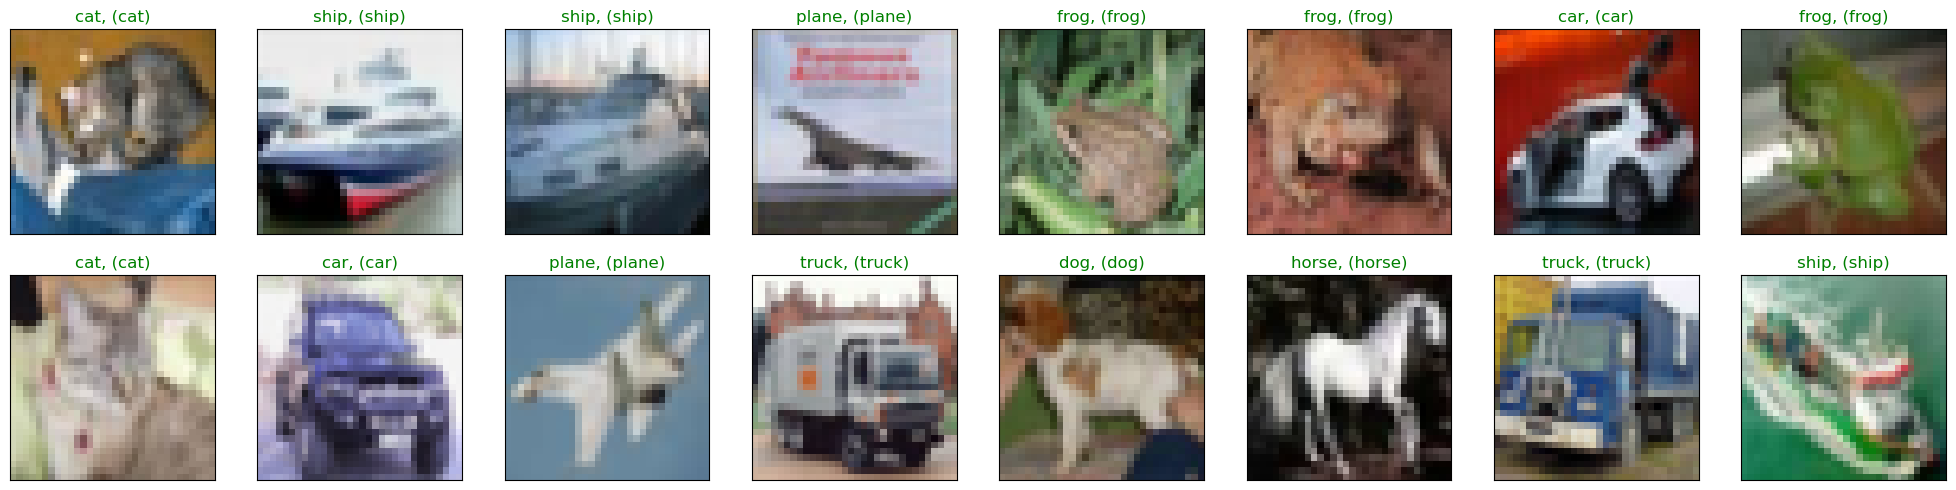

In [19]:
dataiter = iter(testloader)
images, labels = next(dataiter)
images_ = images
images_ = images_.to(device)
labels = labels.to(device)
val_output = net(images_)
_, val_preds = torch.max(val_output, 1)

fig = plt.figure(figsize=(25,4))

correct = torch.sum(val_preds == labels.data).item()

val_preds = val_preds.cpu()
labels = labels.cpu()

print("Accuracy Rate = {}%".format(correct/len(images) * 100))

fig = plt.figure(figsize=(25,25))
for idx in np.arange(16):    
    ax = fig.add_subplot(8, 8, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(
        "{}, ({})".format(classes[val_preds[idx].item()], classes[labels[idx].item()]), 
        color = ("green" if val_preds[idx].item()==labels[idx].item() else "red")
    )

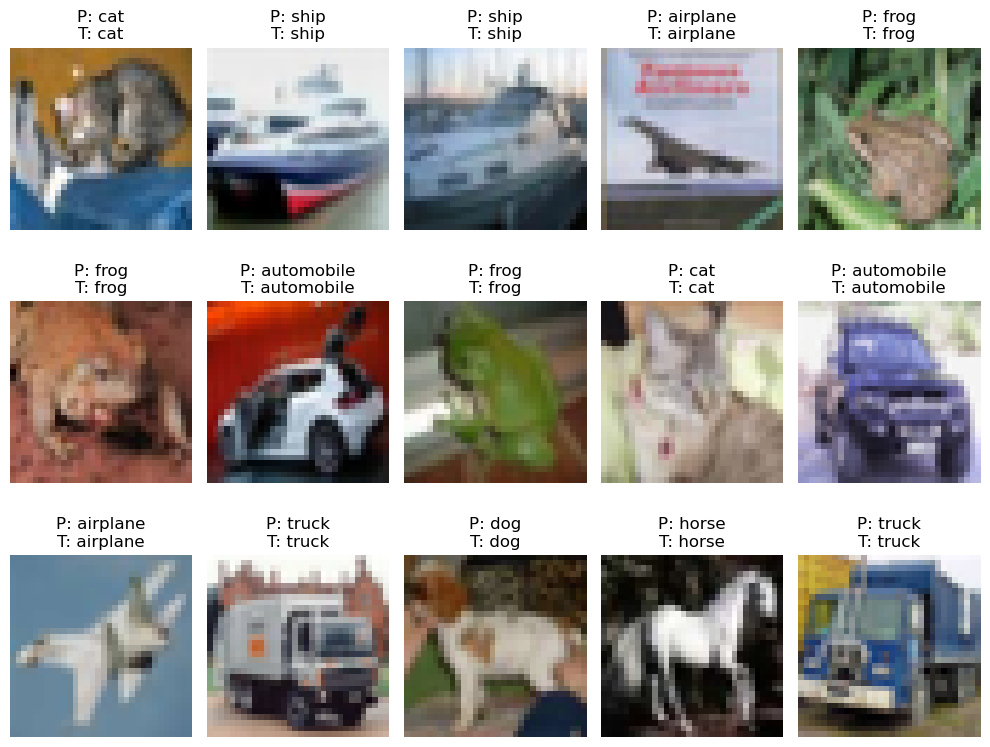

In [20]:
unnormalizer = UnNormalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

show_examples(model=net, data_loader=testloader, unnormalizer=unnormalizer, class_dict=class_dict)

## ResNet18 Batch size 256

In [21]:
batch_size = 256

In [22]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,shuffle=False)

In [23]:
net = ResNet18().to(device)
if device == 'cuda':
    net = nn.DataParallel(net)
    torch.backends.cudnn.benchmark = True

In [24]:
epoch = 100

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3, weight_decay=5e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=3, min_lr=1e-5) 

In [25]:
Acc, Loss, Lr = train(net, trainloader, testloader, epoch, optimizer, criterion, scheduler)

Epoch [  1/100] | Train Loss:1.550973 | Train Acc:43.28% | Test Loss:1.304818 | Test Acc:54.63% | Learning Rate:0.001000 | Time: 00:28
Epoch [  2/100] | Train Loss:1.071259 | Train Acc:61.53% | Test Loss:1.043936 | Test Acc:64.62% | Learning Rate:0.001000 | Time: 00:27
Epoch [  3/100] | Train Loss:0.854222 | Train Acc:69.63% | Test Loss:0.994423 | Test Acc:67.77% | Learning Rate:0.001000 | Time: 00:28
Epoch [  4/100] | Train Loss:0.726839 | Train Acc:74.57% | Test Loss:1.022874 | Test Acc:65.29% | Learning Rate:0.001000 | Time: 00:27
Epoch [  5/100] | Train Loss:0.636972 | Train Acc:78.07% | Test Loss:0.984663 | Test Acc:67.47% | Learning Rate:0.001000 | Time: 00:28
Epoch [  6/100] | Train Loss:0.575611 | Train Acc:80.25% | Test Loss:0.722813 | Test Acc:75.66% | Learning Rate:0.001000 | Time: 00:29
Epoch [  7/100] | Train Loss:0.531170 | Train Acc:81.68% | Test Loss:0.759313 | Test Acc:75.86% | Learning Rate:0.001000 | Time: 00:29
Epoch [  8/100] | Train Loss:0.497769 | Train Acc:83.03

In [26]:
def plot_history(epoches, Acc, Loss, lr=None):
    plt.rcParams['figure.figsize'] = (10.0, 8.0)  # set default size of plots
    plt.rcParams['image.interpolation'] = 'nearest'
    plt.rcParams['image.cmap'] = 'gray'

    epoch_list = range(1,epoches + 1)
    plt.plot(epoch_list, Loss['train_loss'])
    plt.plot(epoch_list, Loss['test_loss'])
    plt.xlabel('epoch')
    plt.ylabel('Loss Value')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    plt.plot(epoch_list, Acc['train_acc'])
    plt.plot(epoch_list, Acc['test_acc'])
    plt.xlabel('epoch')
    plt.ylabel('Acc Value')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    plt.plot(epoch_list, lr)
    plt.xlabel('epoch')
    plt.ylabel('Train LR')
    plt.show()

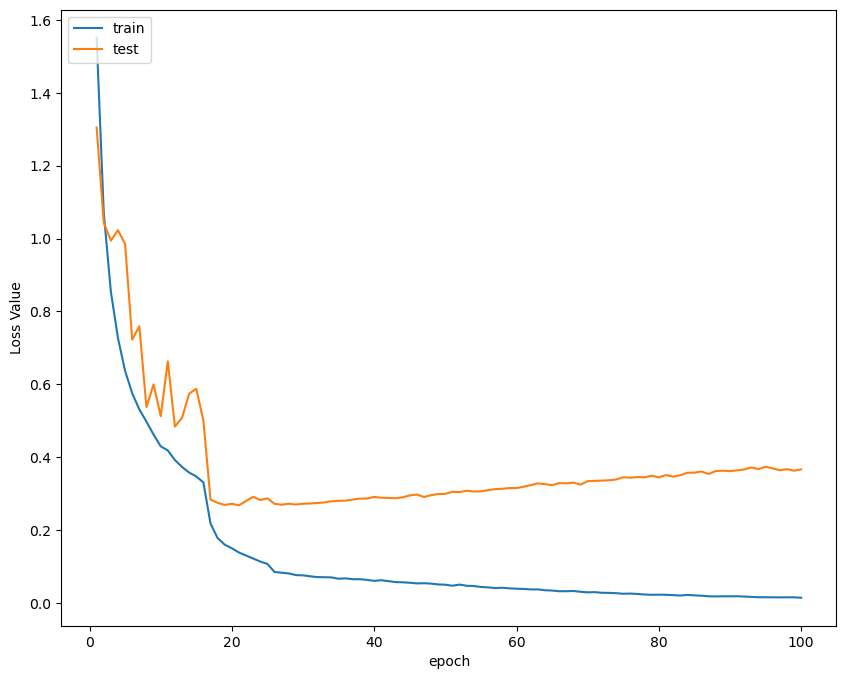

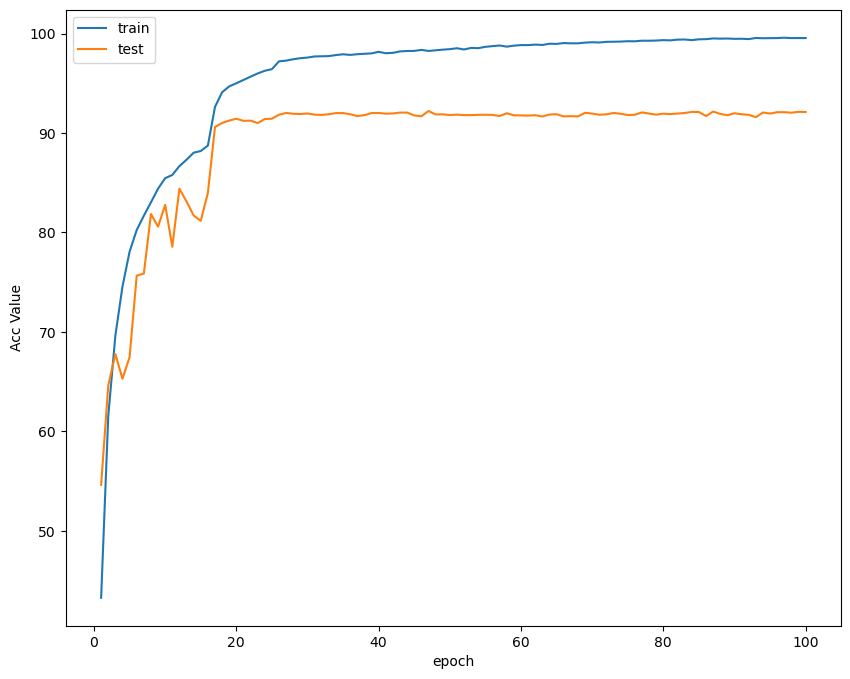

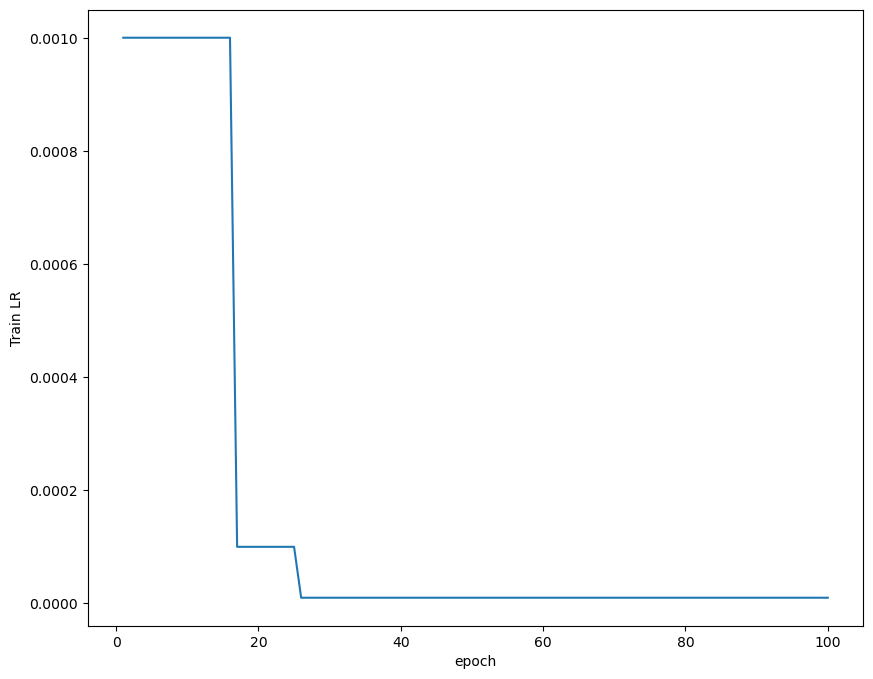

In [27]:
plot_history(epoch, Acc, Loss, Lr)

In [28]:
correct = 0 # Define the number of correctly predicted images, initialized to 0
total = 0 # The total number of pictures participating in the test, also initialized to 0
torch.cuda.empty_cache()
net.eval()
with torch.no_grad():
    for data in testloader: # Loop through each batch
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        net.eval() # Convert the model to test mode
        if hasattr(torch.cuda, 'empty_cache'):
            torch.cuda.empty_cache()
        outputs = net(images) # Enter the network for testing

        # outputs.data is a 4x10 tensor. The value and sequence number of the largest column of each row are formed into a one-dimensional tensor to return, the first is the value tensor, and the second is the sequence number tensor.
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0) # update the number of test images
        correct += (predicted == labels).sum() # update the number of correctly classified images

    print('Accuracy of the network on the 10000 test images: %.2f %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 92.07 %


In [29]:
# Define 2 lists that store the number of correct tests in each class, initialized to 0
class_correct = list(0.for i in range(10))
class_total = list(0.for i in range(10))
net.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        if hasattr(torch.cuda, 'empty_cache'):
            torch.cuda.empty_cache()
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
    #4 group (batch_size) data, output in the same label, marked as 1, otherwise 0
        c = (predicted == labels).squeeze()
        for i in range(len(images)): # Because each batch has 4 images, a small loop of 4 is needed
            label = labels[i] # Accumulate each class separately
            class_correct[label] += c[i]
            class_total[label] += 1
 
 
for i in range(10):
    print('Accuracy of %5s : %.2f %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 93.70 %
Accuracy of   car : 96.30 %
Accuracy of  bird : 89.10 %
Accuracy of   cat : 84.60 %
Accuracy of  deer : 92.40 %
Accuracy of   dog : 85.80 %
Accuracy of  frog : 93.80 %
Accuracy of horse : 94.80 %
Accuracy of  ship : 94.90 %
Accuracy of truck : 95.30 %


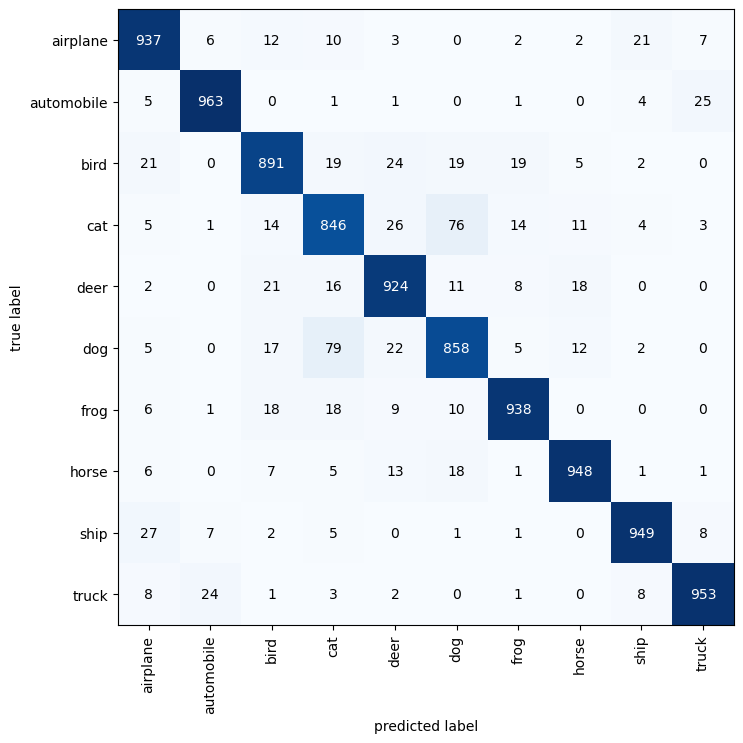

In [30]:
class_dict = {0: 'airplane',
              1: 'automobile',
              2: 'bird',
              3: 'cat',
              4: 'deer',
              5: 'dog',
              6: 'frog',
              7: 'horse',
              8: 'ship',
              9: 'truck'}

mat = compute_confusion_matrix(model=net, data_loader=testloader, device=torch.device('cpu'))
plot_confusion_matrix(mat, class_names=class_dict.values())
plt.show()

In [31]:
def imshow(img):
    img = img / 2 + 0.5
    img = np.transpose(img.numpy(),(1,2,0))
    plt.imshow(img)

Accuracy Rate = 92.96875%


<Figure size 2500x400 with 0 Axes>

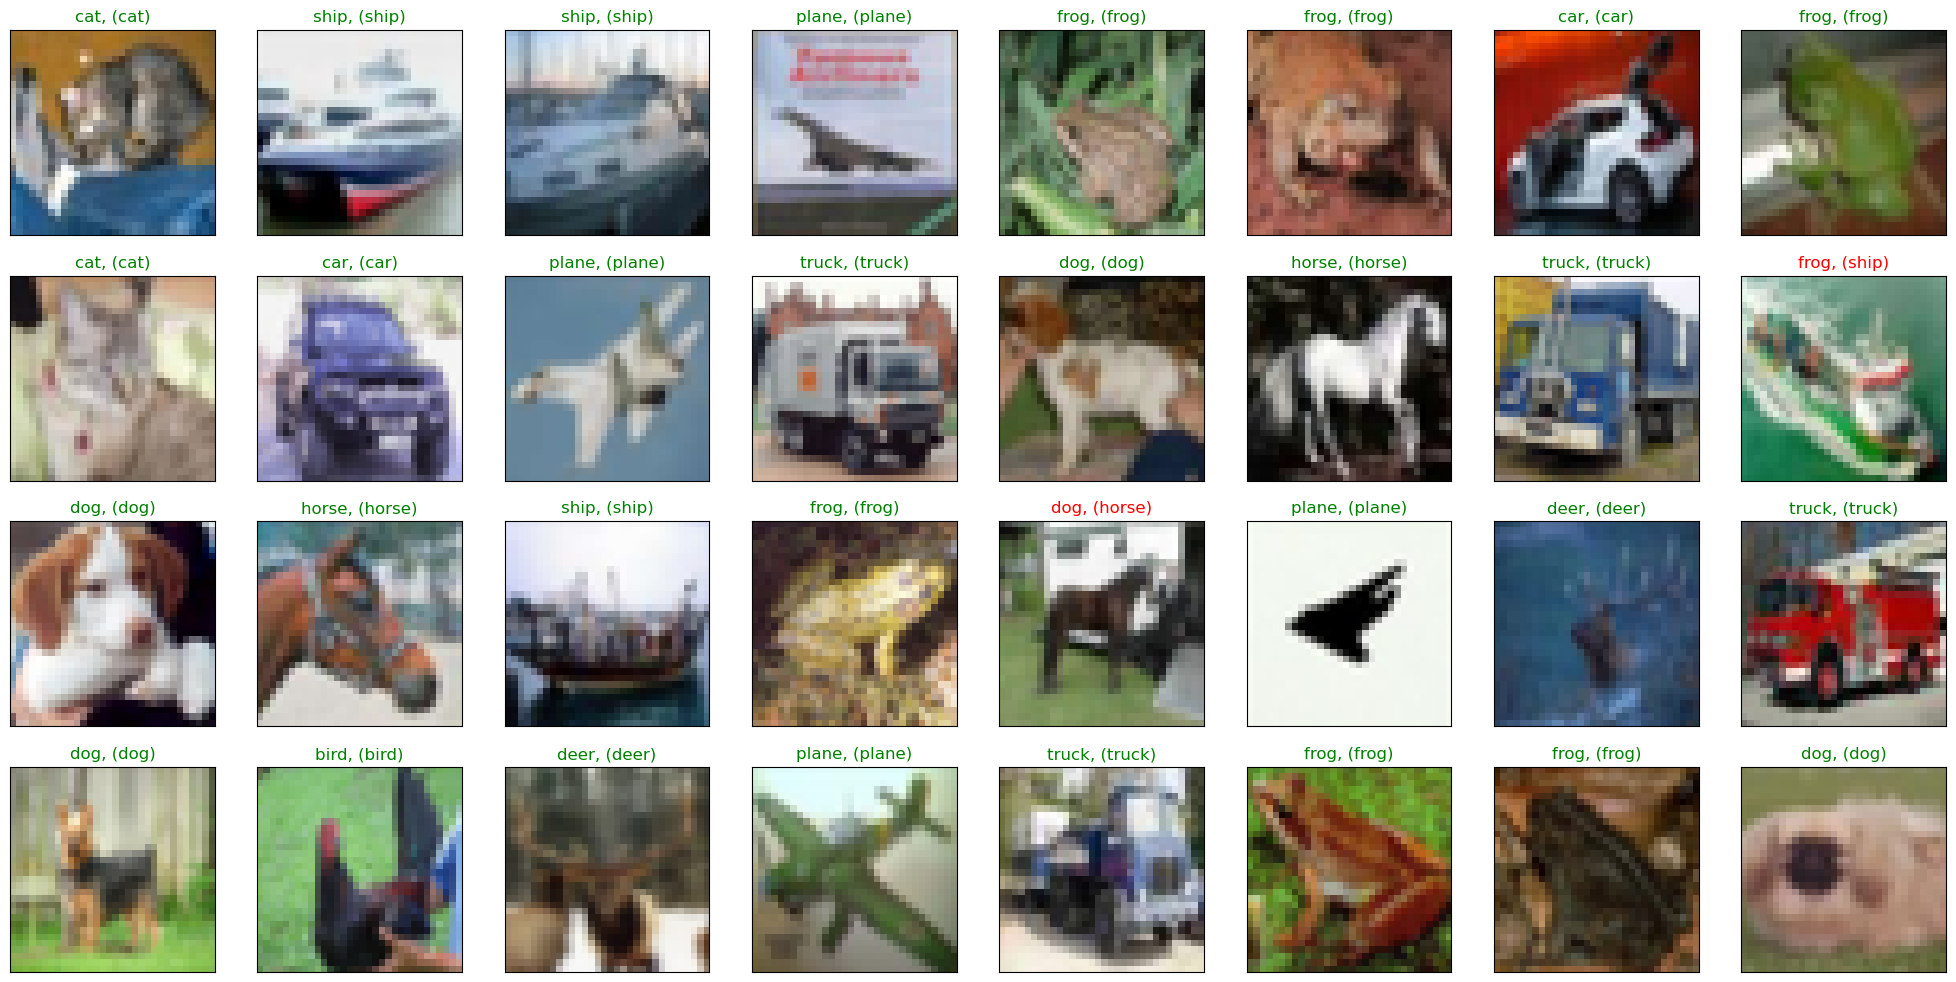

In [32]:
dataiter = iter(testloader)
images, labels = next(dataiter)
images_ = images
images_ = images_.to(device)
labels = labels.to(device)
val_output = net(images_)
_, val_preds = torch.max(val_output, 1)

fig = plt.figure(figsize=(25,4))

correct = torch.sum(val_preds == labels.data).item()

val_preds = val_preds.cpu()
labels = labels.cpu()

print("Accuracy Rate = {}%".format(correct/len(images) * 100))

fig = plt.figure(figsize=(25,25))
for idx in np.arange(32):    
    ax = fig.add_subplot(8, 8, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(
        "{}, ({})".format(classes[val_preds[idx].item()], classes[labels[idx].item()]), 
        color = ("green" if val_preds[idx].item()==labels[idx].item() else "red")
    )

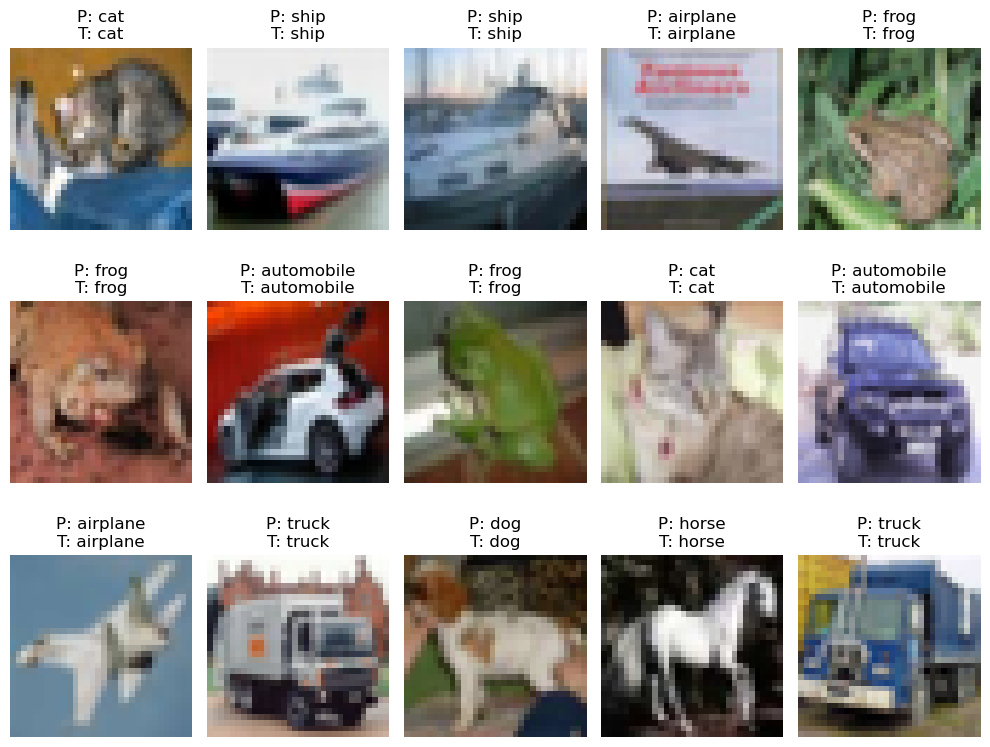

In [33]:
unnormalizer = UnNormalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

show_examples(model=net, data_loader=testloader, unnormalizer=unnormalizer, class_dict=class_dict)

## ResNet18 Batch size 512

In [6]:
batch_size = 512

In [7]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,shuffle=False)

In [8]:
net = ResNet18().to(device)
if device == 'cuda':
    net = nn.DataParallel(net)
    torch.backends.cudnn.benchmark = True

In [9]:
epoch = 100

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3, weight_decay=5e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=3, min_lr=1e-5) 

In [10]:
Acc, Loss, Lr = train(net, trainloader, testloader, epoch, optimizer, criterion, scheduler)

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch [  1/100] | Train Loss:1.626138 | Train Acc:39.92% | Test Loss:1.318494 | Test Acc:52.22% | Learning Rate:0.001000 | Time: 00:32
Epoch [  2/100] | Train Loss:1.134655 | Train Acc:59.04% | Test Loss:2.187556 | Test Acc:46.65% | Learning Rate:0.001000 | Time: 00:26
Epoch [  3/100] | Train Loss:0.880415 | Train Acc:68.62% | Test Loss:0.972230 | Test Acc:66.72% | Learning Rate:0.001000 | Time: 00:28
Epoch [  4/100] | Train Loss:0.724982 | Train Acc:74.49% | Test Loss:0.821589 | Test Acc:71.72% | Learning Rate:0.001000 | Time: 00:26
Epoch [  5/100] | Train Loss:0.629782 | Train Acc:77.90% | Test Loss:0.890319 | Test Acc:71.02% | Learning Rate:0.001000 | Time: 00:27
Epoch [  6/100] | Train Loss:0.563738 | Train Acc:80.62% | Test Loss:0.788444 | Test Acc:74.46% | Learning Rate:0.001000 | Time: 00:26
Epoch [  7/100] | Train Loss:0.515555 | Train Acc:82.32% | Test Loss:0.712179 | Test Acc:76.52% | Learning Rate:0.001000 | Time: 00:26
Epoch [  8/100] | Train Loss:0.473855 | Train Acc:83.60

In [11]:
def plot_history(epoches, Acc, Loss, lr=None):
    plt.rcParams['figure.figsize'] = (10.0, 8.0)  # set default size of plots
    plt.rcParams['image.interpolation'] = 'nearest'
    plt.rcParams['image.cmap'] = 'gray'

    epoch_list = range(1,epoches + 1)
    plt.plot(epoch_list, Loss['train_loss'])
    plt.plot(epoch_list, Loss['test_loss'])
    plt.xlabel('epoch')
    plt.ylabel('Loss Value')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    plt.plot(epoch_list, Acc['train_acc'])
    plt.plot(epoch_list, Acc['test_acc'])
    plt.xlabel('epoch')
    plt.ylabel('Acc Value')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    plt.plot(epoch_list, lr)
    plt.xlabel('epoch')
    plt.ylabel('Train LR')
    plt.show()

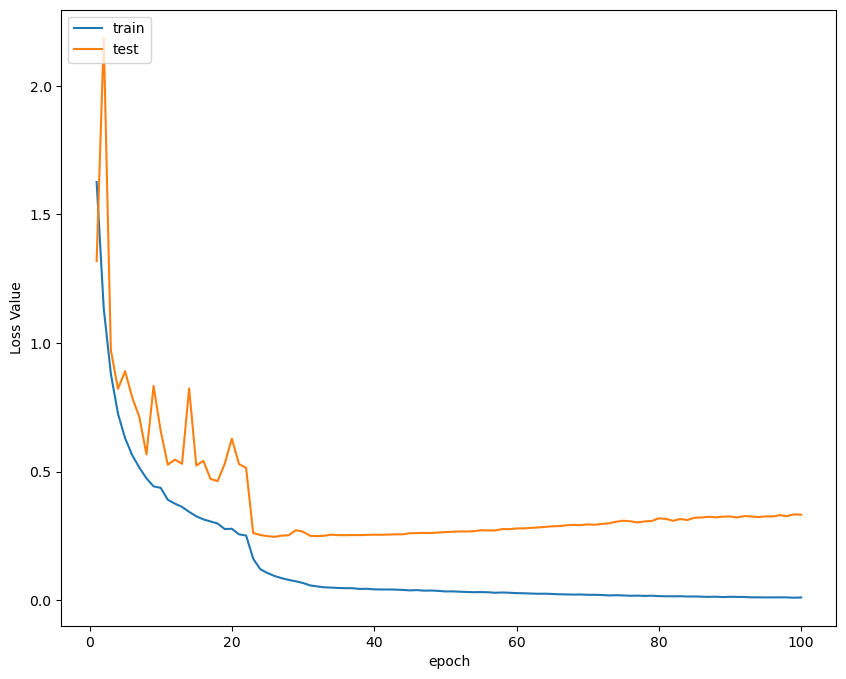

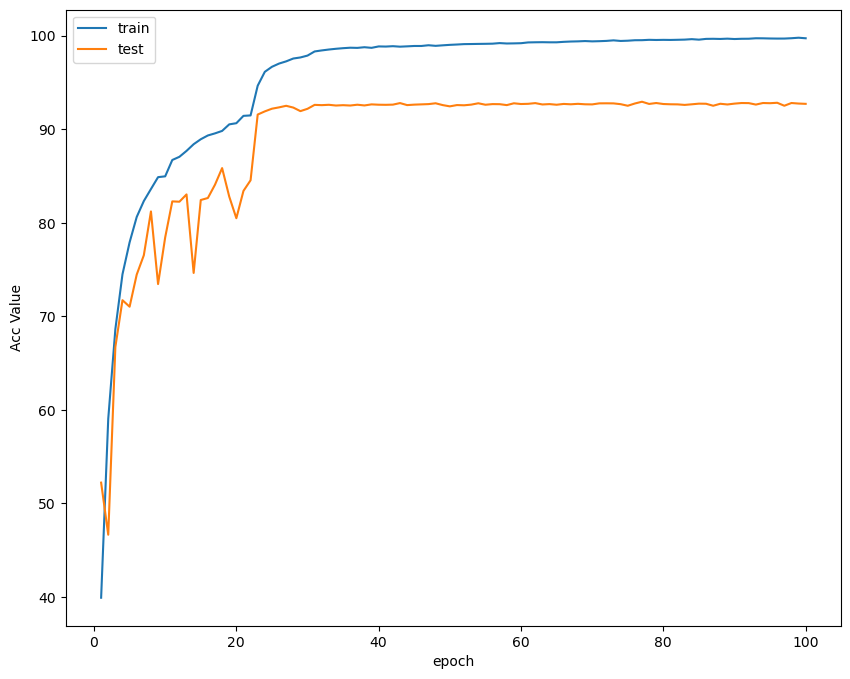

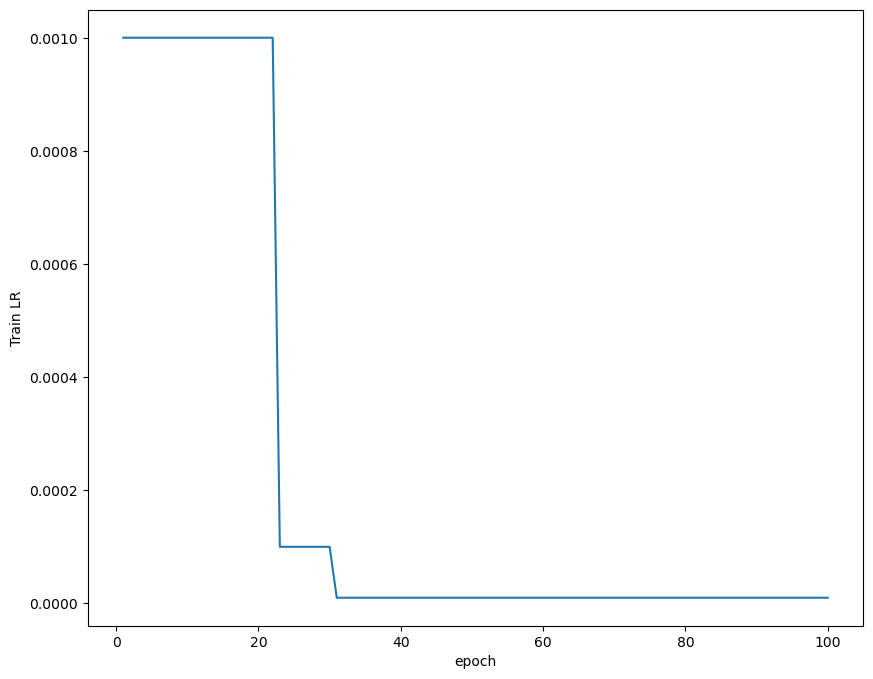

In [12]:
plot_history(epoch, Acc, Loss, Lr)

In [13]:
correct = 0 # Define the number of correctly predicted images, initialized to 0
total = 0 # The total number of pictures participating in the test, also initialized to 0
torch.cuda.empty_cache()
net.eval()
with torch.no_grad():
    for data in testloader: # Loop through each batch
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        net.eval() # Convert the model to test mode
        if hasattr(torch.cuda, 'empty_cache'):
            torch.cuda.empty_cache()
        outputs = net(images) # Enter the network for testing

        # outputs.data is a 4x10 tensor. The value and sequence number of the largest column of each row are formed into a one-dimensional tensor to return, the first is the value tensor, and the second is the sequence number tensor.
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0) # update the number of test images
        correct += (predicted == labels).sum() # update the number of correctly classified images

    print('Accuracy of the network on the 10000 test images: %.2f %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 92.71 %


In [14]:
# Define 2 lists that store the number of correct tests in each class, initialized to 0
class_correct = list(0.for i in range(10))
class_total = list(0.for i in range(10))
net.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        if hasattr(torch.cuda, 'empty_cache'):
            torch.cuda.empty_cache()
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
    #4 group (batch_size) data, output in the same label, marked as 1, otherwise 0
        c = (predicted == labels).squeeze()
        for i in range(len(images)): # Because each batch has 4 images, a small loop of 4 is needed
            label = labels[i] # Accumulate each class separately
            class_correct[label] += c[i]
            class_total[label] += 1
 
 
for i in range(10):
    print('Accuracy of %5s : %.2f %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 94.20 %
Accuracy of   car : 96.50 %
Accuracy of  bird : 90.60 %
Accuracy of   cat : 85.50 %
Accuracy of  deer : 93.00 %
Accuracy of   dog : 88.30 %
Accuracy of  frog : 94.90 %
Accuracy of horse : 94.20 %
Accuracy of  ship : 94.90 %
Accuracy of truck : 95.00 %


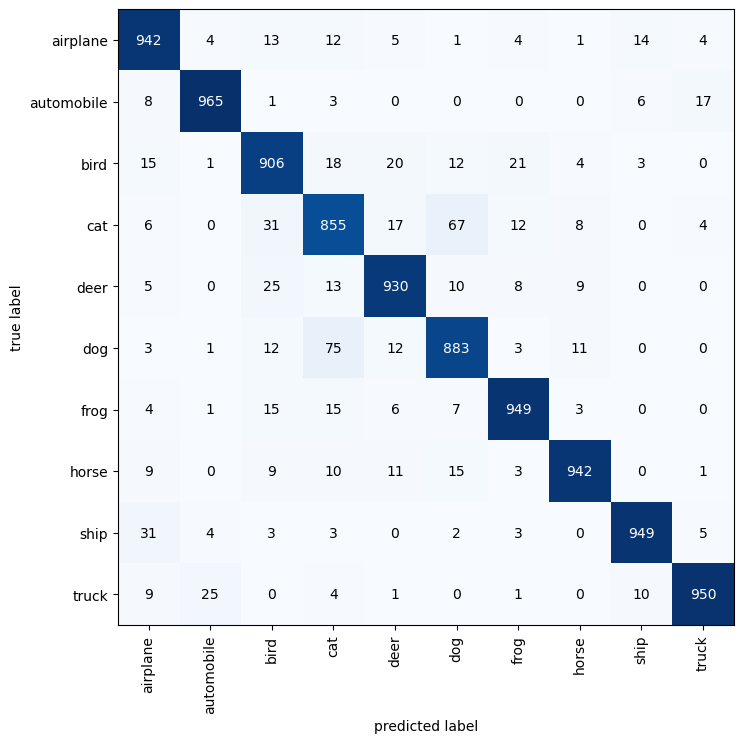

In [15]:
class_dict = {0: 'airplane',
              1: 'automobile',
              2: 'bird',
              3: 'cat',
              4: 'deer',
              5: 'dog',
              6: 'frog',
              7: 'horse',
              8: 'ship',
              9: 'truck'}

mat = compute_confusion_matrix(model=net, data_loader=testloader, device=torch.device('cpu'))
plot_confusion_matrix(mat, class_names=class_dict.values())
plt.show()

In [16]:
def imshow(img):
    img = img / 2 + 0.5
    img = np.transpose(img.numpy(),(1,2,0))
    plt.imshow(img)

Accuracy Rate = 93.75%


<Figure size 2500x400 with 0 Axes>

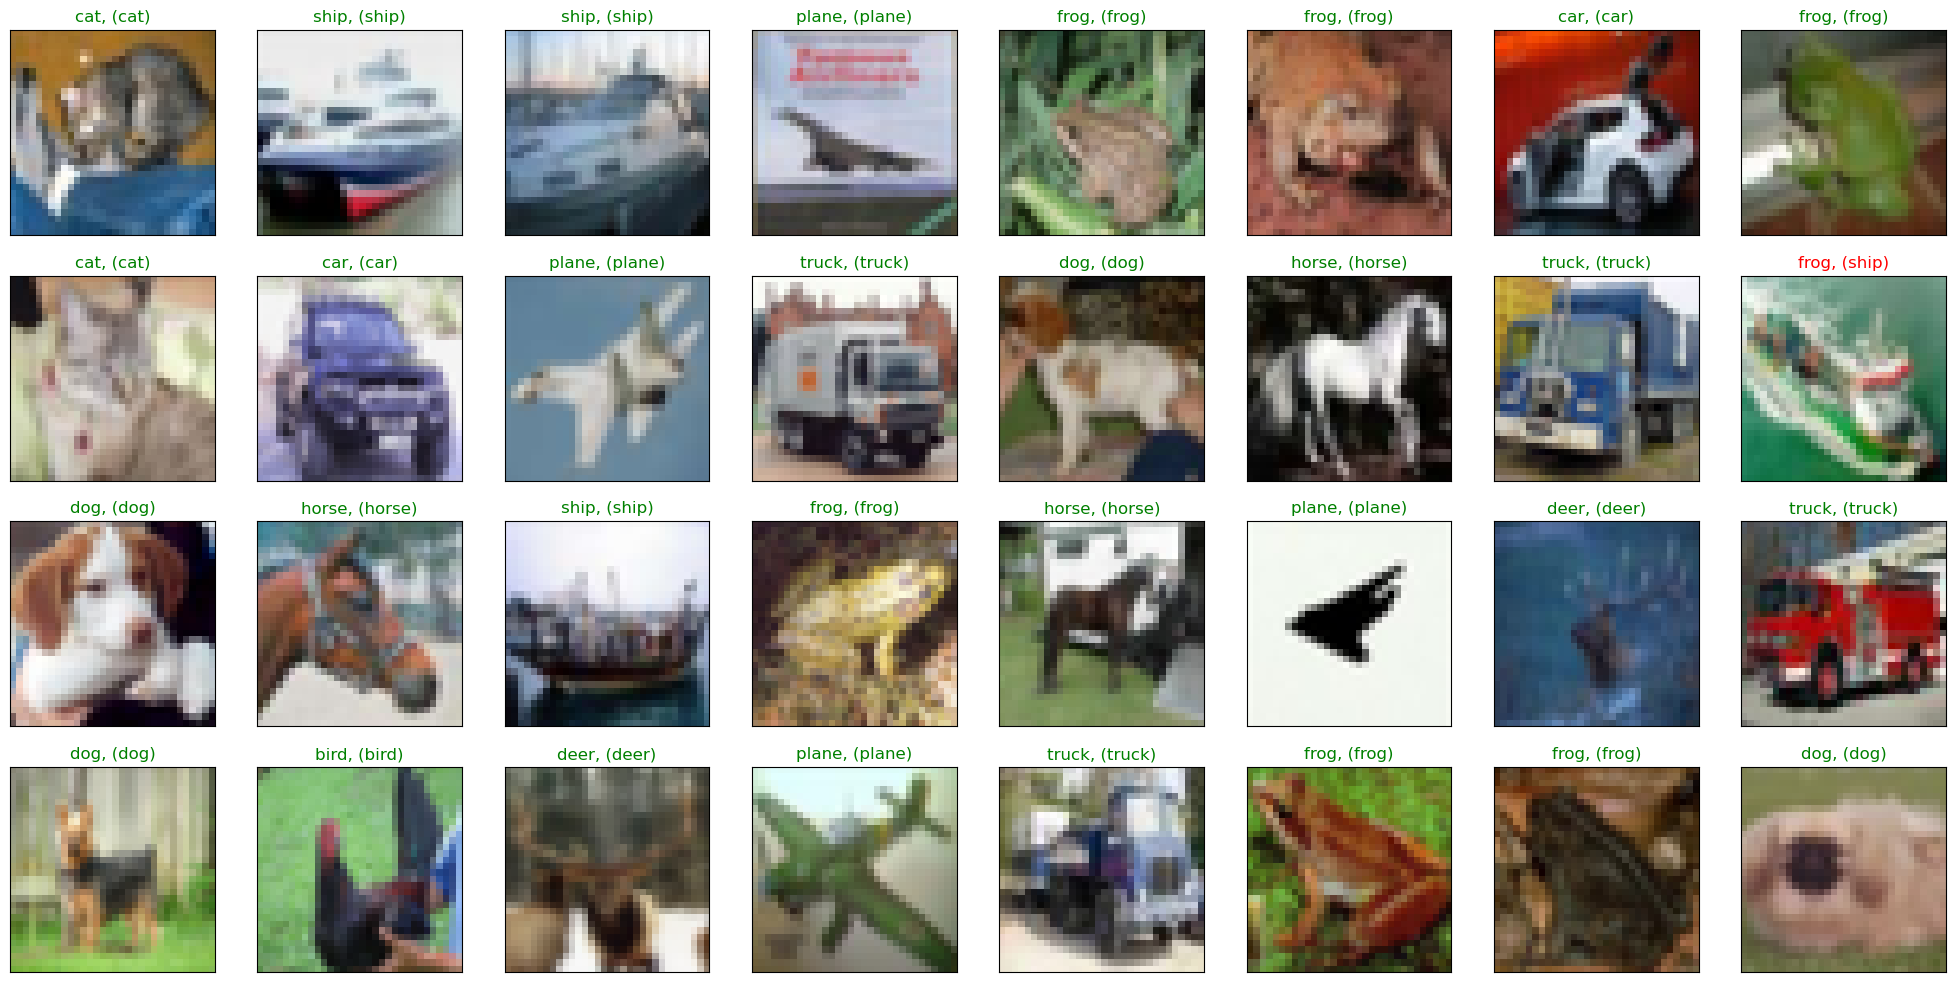

In [17]:
dataiter = iter(testloader)
images, labels = next(dataiter)
images_ = images
images_ = images_.to(device)
labels = labels.to(device)
val_output = net(images_)
_, val_preds = torch.max(val_output, 1)

fig = plt.figure(figsize=(25,4))

correct = torch.sum(val_preds == labels.data).item()

val_preds = val_preds.cpu()
labels = labels.cpu()

print("Accuracy Rate = {}%".format(correct/len(images) * 100))

fig = plt.figure(figsize=(25,25))
for idx in np.arange(32):    
    ax = fig.add_subplot(8, 8, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(
        "{}, ({})".format(classes[val_preds[idx].item()], classes[labels[idx].item()]), 
        color = ("green" if val_preds[idx].item()==labels[idx].item() else "red")
    )

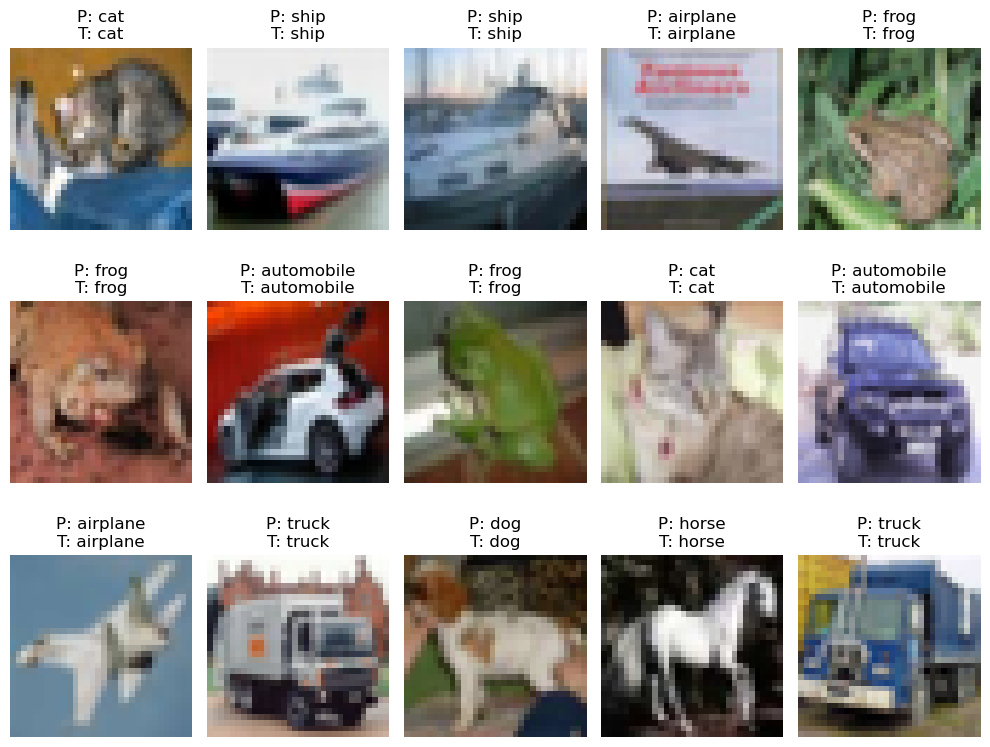

In [18]:
unnormalizer = UnNormalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

show_examples(model=net, data_loader=testloader, unnormalizer=unnormalizer, class_dict=class_dict)